<a href="https://colab.research.google.com/github/RicoStaedeli/ML-Eurosat/blob/main/Track_2_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Notebook for EuroSAT classification
This Notebook is for the Kaggle Coding Challenge https://www.kaggle.com/competitions/8-860-1-00-coding-challenge-2025/overview
Dataset: EuroSAT https://github.com/phelber/EuroSAT
This is **track_2** with a pretrained CNN.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Because loading this much images from Google Drive is not a good solution the dataset is loaded in the colab instance for better performance.

In [ ]:
!cp '/content/drive/MyDrive/HSG/ML/Project/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized.zip' /content/

!unzip '/content/Eurosat_train_dataset_npy_withoutB10_notNormalized.zip' -d /content/Datasets

## Setup

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import random
import pandas as pd
import os
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torchvision.transforms as transforms
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Band Names for Sentinel-2 Images, B10 of the original Sentinel-2 image of the EuroSAT image was removed
band_names = np.array(["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B9", "B11", "B12"])

In [ ]:
euroSAT_classes = {"AnnualCrop": 0, "Forest": 1, "HerbaceousVegetation": 2, "Highway": 3, "Industrial": 4, "Pasture": 5,
                   "PermanentCrop": 6, "Residential": 7, "River": 8, "SeaLake": 9}

In [ ]:
# This Number is used to generate all the different saving directories
TRAINING_NUMBER = 48
TRACK = "track_2"

IMAGE_RESOLUTION = (64, 64)
################################################################################
######################### Image and Features    ################################
################################################################################

# RGB Bands used for Training
RGB_BANDS = np.array(["B02", "B03", "B04"])

# Other bands to use for training
OTHER_BANDS = np.array([])

# Indices to use in Training
SELECTED_INDICES = np.array(["NDVI"])

TOTAL_FEATURES = RGB_BANDS.shape[0] + OTHER_BANDS.shape[0] + SELECTED_INDICES.shape[0]
SELECTED_BANDS = np.concatenate([RGB_BANDS, OTHER_BANDS])

# Calculate index from names array for later code
SELECTED_BANDS_IDX = np.array([np.where(band_names == band)[0][0] for band in SELECTED_BANDS])

# Count of classes for prediction. Used in CNN output layer
NUMB_PREDICTION_CLASSES = len(euroSAT_classes)

################################################################################
######################### Training Parameters   ################################
################################################################################

EPOCHS = 120
BATCH_SIZE = 32
LEARNING_RATE = 0.001
PATIENCE = 10
WEIGHT_DECAY = 0.0001
LABEL_SMOOTHING = 0.1
IMAGE_AUGMENTATION = True

# augmentation type
USE_CUTMIX = False
USE_MIXUP = False
ALPHA = 1

# The training script provides a method to clean outliers from the dataset. With this flag the cleaning can be activated
CLEAN_OUTLIERS = True

# Set seeds for reproducibility
# random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Use GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

################################################################################
######################### Path Variables.        ###############################
################################################################################

#Directory containing the trainings images. These images are generated from the original EuroSAT images using the first 12 Bands.
train_image_dir = "/content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized"

#Directory containing the evaluation images. These images are given by the Code Challenge
eval_image_dir = "/content/drive/MyDrive/HSG/ML/Project/Datasets/Challenge Testdata/testset/testset"

#Path to save the trained model for later inference
model_save_dir = f"/content/drive/MyDrive/HSG/ML/Project/Trained Models/Model_Training_{TRAINING_NUMBER}/"
os.makedirs(model_save_dir, exist_ok=True)

#Path to save the csv with the predictions of the evaluation images for the submission
csv_predictions_dir = f'/content/drive/MyDrive/HSG/ML/Project/Evaluation/predictions_{TRAINING_NUMBER}/'
os.makedirs(csv_predictions_dir, exist_ok=True)

#Directory to save logs of tensorboard training data
log_dir = f"/content/drive/MyDrive/HSG/ML/Project/Training Notebooks/Training Files/Tensorboard_Logs/Training_{TRAINING_NUMBER}"
os.makedirs(log_dir, exist_ok=True)

Calculation of different indices for Sentinel-2 images [Indices Calculation]( https://d-nb.info/1239826591/34)

In [ ]:
INDICES_FUNCTIONS = {
    # Moisture Stress Index - assesses vegetation water content/stress
    "MSI": lambda bands: (bands["B8A"] - bands["B11"]) / (bands["B8A"] + bands["B11"] + 1e-6),

    # Normalized Difference Snow Index - used for snow and ice detection
    "NDSI": lambda bands: (bands["B03"] - bands["B11"]) / (bands["B03"] + bands["B11"] + 1e-6),

    # Normalized Difference Water Index - highlights water bodies
    "NDWI": lambda bands: (bands["B03"] - bands["B08"]) / (bands["B03"] + bands["B08"] + 1e-6),

    # Normalized Difference Vegetation Index - general vegetation health and density
    "NDVI": lambda bands: (bands["B08"] - bands["B04"]) / (bands["B08"] + bands["B04"] + 1e-6),

    # Green NDVI - vegetation stress, especially nitrogen concentration
    "GNDVI": lambda bands: (bands["B08"] - bands["B03"]) / (bands["B08"] + bands["B03"] + 1e-6),

    # Blue NDVI - used in aquatic vegetation and chlorophyll studies
    "BNDVI": lambda bands: (bands["B08"] - bands["B02"]) / (bands["B08"] + bands["B02"] + 1e-6),

    # Red Edge NDVI - detects chlorophyll content and plant stress
    "NDRE": lambda bands: (bands["B08"] - bands["B05"]) / (bands["B08"] + bands["B05"] + 1e-6),

    # Normalized Difference Chlorophyll Index - indicates chlorophyll concentration
    "NDCI": lambda bands: (bands["B05"] - bands["B04"]) / (bands["B05"] + bands["B04"] + 1e-6),

    # Normalized Burn Ratio - identifies burned areas post-fire
    "NBR": lambda bands: (bands["B08"] - bands["B12"]) / (bands["B08"] + bands["B12"] + 1e-6),

    # Normalized Difference Built-up Index - highlights urban/built-up areas
    "NDBI": lambda bands: (bands["B11"] - bands["B08"]) / (bands["B08"] + bands["B11"] + 1e-6),

    # Modified Soil Adjusted Vegetation Index - enhances vegetation signal in soil-heavy areas
    "MSAVI": lambda bands: (2 * bands["B08"] + 1 - np.sqrt(
        (2 * bands["B08"] + 1) ** 2 - 8 * (bands["B08"] - bands["B04"]))) / 2,

    # Enhanced Vegetation Index - improves sensitivity in high biomass areas
    "EVI": lambda bands: 2.5 * (bands["B08"] - bands["B04"]) / (
            bands["B08"] + 6 * bands["B04"] - 7.5 * bands["B02"] + 1 + 1e-6),

    # Soil Adjusted Vegetation Index - minimizes soil brightness influence
    "SAVI": lambda bands, L=0.5: ((bands["B08"] - bands["B04"]) / (bands["B08"] + bands["B04"] + L + 1e-6)) * (1 + L),

    # Normalized Difference Moisture Index - detects vegetation moisture
    "NDMI": lambda bands: (bands["B08"] - bands["B11"]) / (bands["B08"] + bands["B11"] + 1e-6),

    # Anthocyanin Reflectance Index - used to estimate anthocyanin pigments in leaves
    "ARI": lambda bands: (1 / (bands["B03"] + 1e-6)) - (1 / (bands["B05"] + 1e-6)),

    # Built-Up Index - composite index to highlight urbanization vs vegetation
    "BUI": lambda bands, L=0.5: ((bands["B11"] - bands["B08"]) / (bands["B11"] + bands["B08"] + 1e-6) -
                                 (((bands["B08"] - bands["B04"]) * (1 + L)) / (bands["B08"] + bands["B04"] + L + 1e-6) +
                                  (bands["B03"] - bands["B11"]) / (bands["B03"] + bands["B11"] + 1e-6)) / 2)
}

## Dataset creation
In this section the dataset for the training is prepared and preprocessed. These steps are done in this section:
- normalize and transform images
- proprocess dataset to have the form of a label and a coresponding image
- augment images
- create train/test split

In [ ]:
def calculate_mean_std(loader):
    """
    Calculates the per-channel mean and standard deviation of a dataset from a DataLoader.
    This is typically used for normalizing image data before training deep learning models.

    Args:
        loader (DataLoader): A PyTorch DataLoader that yields batches of images in the form
            (images, labels, paths), where `images` is a tensor of shape [batch_size, channels, height, width].

    Returns:
        Tuple[Tensor, Tensor]: A tuple containing two tensors:
            - mean (Tensor): The mean pixel value per channel.
            - std (Tensor): The standard deviation of pixel values per channel.
    """
    channel_sum, channel_squared_sum, num_pixels = 0, 0, 0

    for images, _, paths in loader:
        # images shape: [batch, channels, H, W]
        channel_sum += images.sum(dim=[0, 2, 3])
        channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])
        num_pixels += images.size(0) * images.size(2) * images.size(3)

    mean = channel_sum / num_pixels
    std = (channel_squared_sum / num_pixels - mean ** 2).sqrt()
    return mean, std

def mixup_data(x, y, alpha=1.0):
    """
    MixUp: Data augmentation technique that creates synthetic training examples
    by combining pairs of inputs and their labels with a weighted average.


    Args:
        x (Tensor): Input batch of data.
        y (Tensor): Corresponding labels.
        alpha (float): Hyperparameter controlling the strength of interpolation.

    Returns:
        mixed_x (Tensor): Mixed input data.
        y_a (Tensor): Original targets.
        y_b (Tensor): Shuffled targets.
        lam (float): Mixing coefficient.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def cutmix_data(x, y, alpha=1.0):
    """
    CutMix: Data augmentation method that replaces a random patch of an image
    with a patch from another image and mixes the labels proportionally.

    Args:
        x (Tensor): Input batch of images (B, C, H, W).
        y (Tensor): Corresponding labels.
        alpha (float): Hyperparameter controlling the area of the patch.

    Returns:
        x (Tensor): Augmented batch of images.
        y_a (Tensor): Original targets.
        y_b (Tensor): Shuffled targets.
        lam (float): Adjusted lambda based on area of the patch.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size, _, h, w = x.size()
    index = torch.randperm(batch_size).to(x.device)

    # Bounding box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    # Uniform center
    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    y_a, y_b = y, y[index]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(-1) * x.size(-2)))

    return x, y_a, y_b, lam

In [ ]:
class EuroSatDataset(Dataset):
    """
    PyTorch Dataset class for loading and processing EuroSAT Sentinel-2 imagery stored as .npy files.
    Images are stored in format (64,64,12). The Band 10 of the original EutoSAT Dataset is removed in the images.

    This dataset supports:
    - Loading images and their corresponding class labels (extracted from filenames).
    - Enhancing images with additional spectral indices (e.g., NDVI, NDBI, etc.).
    - Selecting specific spectral bands from the Sentinel-2 data.
    - Applying optional image transformations (e.g., normalization, augmentations).

    The class assumes that filenames are formatted with the class label as a prefix,
    e.g., 'AnnualCrop_12.npy' will be labeled as class 0 (based on euroSAT_classes mapping).

    Attributes:
        image_paths (list of str): List of file paths to the .npy image files.
        transform (callable, optional): Optional transform to apply on a sample.
        load_labels (bool): Whether to extract and return labels from filenames.
        selected_band_idx (list of int): Indices of the bands to retain from the original image.
        selected_indices (list of str): List of index names to compute and append as extra channels.
    """

    def __init__(self, image_paths, transform=None, load_labels=True, selected_band_idx=SELECTED_BANDS_IDX,
                 selected_indices=SELECTED_INDICES):
        self.image_paths = image_paths
        self.transform = transform
        self.load_labels = load_labels
        self.selected_band_idx = selected_band_idx
        self.selected_indices = selected_indices

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = np.load(image_path).astype(np.float32)

        if self.load_labels:
            label = torch.tensor(self._extract_label_from_filename(image_path), dtype=torch.long)
        else:
            label = -1  # Dummy label

        image = self.create_image_with_features(image)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image, label, image_path

    @staticmethod
    def _extract_label_from_filename(path):
        label_str = os.path.basename(path).split("_")[0]
        return euroSAT_classes[label_str]

    def __len__(self):
        return len(self.image_paths)

    def create_image_with_features(self, image):
        """
        This method creates additionally feature for Sentinel-2 images.
        The initially image is enhanced with different indices which are combinations
        of multiple bands of the Sentinel-2 image.

        Parameters:
            image: np.array of shape (H,W,C), input image.

        Returns:
            combined: np.array of shape (H,W,num_selected_bands+num_indices)
        """
        H, W, _ = image.shape
        num_selected_bands = len(self.selected_band_idx)
        num_indices = len(self.selected_indices)

        combined = np.zeros((H, W, num_selected_bands + num_indices), dtype=np.float32)

        # Add native bands
        combined[:, :, :num_selected_bands] = image[:, :, self.selected_band_idx]

        bands = {name: image[:, :, idx] for idx, name in enumerate(band_names)}

        # Add computed indices
        for i, index_name in enumerate(self.selected_indices):
            if index_name not in INDICES_FUNCTIONS:
                raise ValueError(f"Index '{index_name}' is not defined.")
            combined[:, :, num_selected_bands + i] = INDICES_FUNCTIONS[index_name](bands)

        return combined

**Image Augmentation**
- random flip and rotate images
- random adjust color and brightness from RGB bands
- random implement gaussian noise
- band dropout --> randomly remove one band from image

In [ ]:
class CustomAugment:
    def __call__(self, image):
        return self.augment_image(image)

    def augment_image(self, image):
        """
        Parameters:
        - image: torch.Tensor with shape (channels, height, width)

        Returns:
        - image_augmented: torch.Tensor with augmented channels
        """
        rgb_channels = image[:3, :, :]
        extra_channels = image[3:, :, :]

        # Random flips
        if random.random() > 0.5:
            rgb_channels = TF.hflip(rgb_channels)
            extra_channels = TF.hflip(extra_channels)
        if random.random() > 0.5:
            rgb_channels = TF.vflip(rgb_channels)
            extra_channels = TF.vflip(extra_channels)

        # Random rotations
        angle = random.choice([0, 90, 180, 270])
        if angle:
            rgb_channels = TF.rotate(rgb_channels, angle)
            extra_channels = TF.rotate(extra_channels, angle)

        # Recombine channels
        image_augmented = torch.cat([rgb_channels, extra_channels], dim=0)

        return image_augmented

In [ ]:
class ResizeTensor:
    """
    This class is used to Resize image tensors. For some pretrained model it is usefull to resize images to 224x224 pixels
    """
    def __init__(self, size=(224, 224)):
        self.size = size

    def __call__(self, image):
        # Expect image shape: (C, H, W)
        image = image.unsqueeze(0)  # (1, C, H, W)
        image = F.interpolate(image, size=self.size, mode='bilinear', align_corners=False)
        return image.squeeze(0)  # Back to (C, H, W)

Create Train/Test Split of image paths

In [ ]:
image_paths = [os.path.join(train_image_dir, fileName) for fileName in os.listdir(train_image_dir) if
               fileName.endswith('.npy')]
# image_paths = image_paths[:50]

image_paths_train, image_paths_eval = train_test_split(
    image_paths, test_size=0.2, random_state=43
)

Calculate Mean and standard Deviation of Training Dataset for Normalization

In [ ]:
train_dataset = EuroSatDataset(image_paths_train)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_mean, train_std = calculate_mean_std(train_loader)

mean_values = train_mean.tolist()
std_values = train_std.tolist()

print("Training mean:", ["{:.6f}".format(m) for m in mean_values])
print("Training std:", ["{:.6f}".format(s) for s in std_values])

Training mean: ['1115.618042', '1040.397217', '944.271667', '0.348514']
Training std: ['332.518799', '394.318390', '593.196533', '0.330933']


In [ ]:
# Use calculated mean and std for normalization
if IMAGE_AUGMENTATION:
    print("Create Transformation with Image Augmentation")
    train_transforms = transforms.Compose([
        ResizeTensor(IMAGE_RESOLUTION),
        CustomAugment(),
        transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
    ])
else:
    print("Create Transformation without Image Augmentation")
    train_transforms = transforms.Compose([
        ResizeTensor(IMAGE_RESOLUTION),
        transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
    ])

val_transforms = transforms.Compose([
    ResizeTensor(IMAGE_RESOLUTION),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

Create Transformation with Image Augmentation


In [ ]:
# Create Datasets with transformation (data augmentation and normalization)
train_dataset = EuroSatDataset(image_paths_train, transform=train_transforms)
val_dataset = EuroSatDataset(image_paths_eval, transform=val_transforms)

In [ ]:
# Update DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Check Augmentation and Normalization

### Normalization Analysis
To analyse the normalization the mean and std from the train images can be calculated. If normalization works correct: mean = 0, std = 1

In [ ]:
#Check if normalization has worked
images, _, _ = next(iter(train_loader))
mean_check = images.mean(dim=[0, 2, 3])
std_check = images.std(dim=[0, 2, 3])

print("After normalization (train set):")
print("Mean:", ["{:.6f}".format(m) for m in mean_check])
print("Std:", ["{:.6f}".format(s) for s in std_check])

After normalization (train set):
Mean: ['0.126049', '0.169201', '0.183674', '-0.006215']
Std: ['1.037475', '1.051581', '1.081068', '0.930202']


### Augmentation Analysis
To check augmentation the normalization has to be remmoved temporarly

In [ ]:
# Use calculated mean and std for normalization
train_transforms_analysis = transforms.Compose([
    CustomAugment(),
])

val_transforms_analysis = transforms.Compose([
])

In [ ]:
# Get an example from your dataset
random_image = train_image_dir + "/AnnualCrop_544.npy"
original_image_tensor, _, _ = EuroSatDataset([random_image], transform=val_transforms_analysis)[0]
augmented_image_tensor, _, _ = EuroSatDataset([random_image], transform=train_transforms_analysis)[0]

**Check RGB image visualy**
<br>
If augmentations (flip, rotation, brightness/contrast) are correctly applied, it should clearly be visual differences across multiple runs.

In [ ]:
def to_rgb(image):
    rgb = image[:, :, [2, 1, 0]]
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    return np.clip(rgb, 0, 1)

def show_rgb(original, transformed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(to_rgb(original))
    plt.title("Origanl RGB image")

    plt.subplot(1, 2, 2)
    plt.imshow(to_rgb(transformed))
    plt.title("Transformed RGB image")

    plt.tight_layout()
    plt.show()

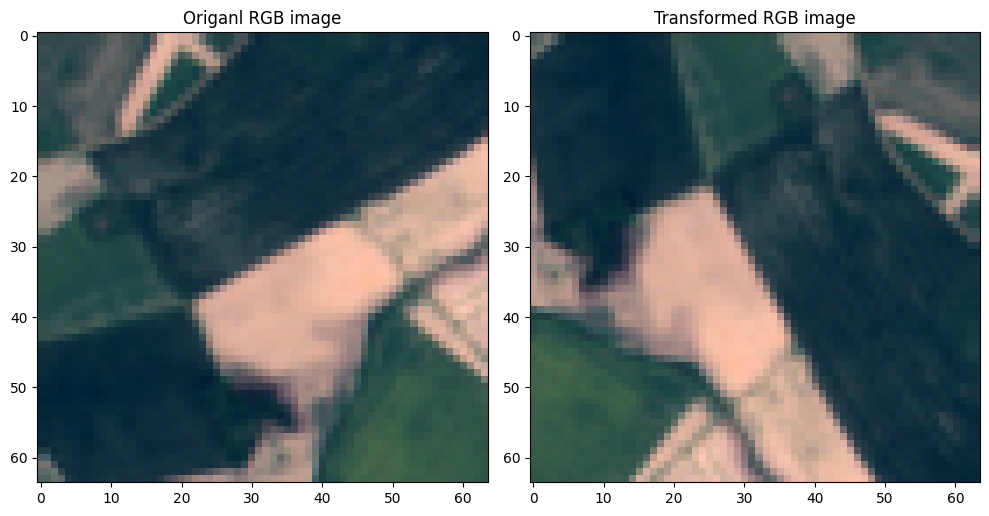

In [ ]:
# Convert tensor back to numpy for plotting
image_np_original = original_image_tensor.numpy().transpose(1, 2, 0)  # (H, W, C)
image_np_augmented = augmented_image_tensor.numpy().transpose(1, 2, 0)  # (H, W, C)
show_rgb(image_np_original, image_np_augmented)

**Check Augmentation numerical** <br>
Image should rotate

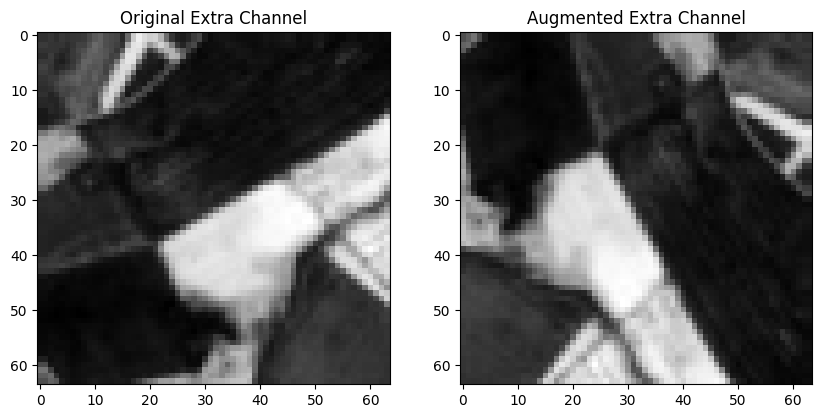

In [ ]:
# Check if non-RGB channels were transformed identically (spatial transformations)
# Pick one extra channel to compare visually
extra_channel_index = 2  # arbitrary choice beyond RGB
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image_tensor[extra_channel_index, :, :], cmap='gray')
axes[0].set_title("Original Extra Channel")
axes[1].imshow(augmented_image_tensor[extra_channel_index, :, :], cmap='gray')
axes[1].set_title("Augmented Extra Channel")
plt.show()

**Statisctical Tests** <br>
Augmented images should have slightly different statistics (mean/std) due to jitter and spatial transformations.

In [ ]:
original_mean = original_image_tensor.mean().item()
augmented_mean = augmented_image_tensor.mean().item()

original_std = original_image_tensor.std().item()
augmented_std = augmented_image_tensor.std().item()

print(f"Original Mean: {original_mean:.4f}, Augmented Mean: {augmented_mean:.4f}")
print(f"Original Std: {original_std:.4f}, Augmented Std: {augmented_std:.4f}")

Original Mean: 862.5991, Augmented Mean: 862.5991
Original Std: 642.4533, Augmented Std: 642.4533


**Color Jitter** <br>
You should see clear differences in RGB due to brightness/contrast jitter, while extra channels should mostly differ due to spatial transformations, not color jitter.

In [ ]:
rgb_original = original_image_tensor[:3].numpy()
rgb_augmented = augmented_image_tensor[:3].numpy()

extra_original = original_image_tensor[3:].numpy()
extra_augmented = augmented_image_tensor[3:].numpy()

print("RGB Mean Difference:", np.mean(rgb_augmented - rgb_original))
print("Extra Channel Mean Difference (should be spatially transformed only):",
      np.mean(extra_augmented - extra_original))

RGB Mean Difference: 0.0
Extra Channel Mean Difference (should be spatially transformed only): 0.0


## Data Analytics
In this section the data is further analyzed. The following steps are done in this section:
- Check label with coresponding image to ensure that no mistakes are done when generate an integer value for the label
- Check distribution of lables in training dataset
- Check shape of the data

In [ ]:
#Analayze the dataset for training
print(f"Total images in dataset: {len(image_paths)}")
print(f"Total images in train_dataset: {len(train_dataset)}")
print(f"Total images in val_dataset: {len(val_dataset)}")

Total images in dataset: 27000
Total images in train_dataset: 21600
Total images in val_dataset: 5400


### Check labeling
With this code the label and the corresponding image path is printed. Manually check if the same label number is mapped to the same class in train and evaluation dataset.

In [ ]:
for i in range(1, 10):
    _, label, path = train_dataset[i]
    print(f"Label: {label}, Path; {path}")

Label: 7, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Residential_1090.npy
Label: 5, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Pasture_2.npy
Label: 0, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/AnnualCrop_1166.npy
Label: 0, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/AnnualCrop_248.npy
Label: 7, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Residential_212.npy
Label: 3, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Highway_141.npy
Label: 2, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/HerbaceousVegetation_2187.npy
Label: 2, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/HerbaceousVegetation_1990.npy
Label: 5, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Pasture_157.npy


In [ ]:
for i in range(1, 10):
    _, label, path = val_dataset[i]
    print(f"Label: {label}, Path; {path}")

Label: 3, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Highway_1582.npy
Label: 7, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Residential_510.npy
Label: 9, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/SeaLake_1266.npy
Label: 6, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/PermanentCrop_1836.npy
Label: 7, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Residential_1924.npy
Label: 6, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/PermanentCrop_460.npy
Label: 5, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Pasture_155.npy
Label: 7, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Residential_2337.npy
Label: 7, Path; /content/Datasets/Eurosat_train_dataset_npy_withoutB10_notNormalized/Residential_953.npy


In [ ]:
train_ids = set(train_dataset.image_paths)  # Adjust based on your dataset's attributes
val_ids = set(val_dataset.image_paths)

leakage = train_ids.intersection(val_ids)
print(f"Overlapping images: {len(leakage)}")
if leakage:
    print(leakage)

Overlapping images: 0


### Print distribution of labels
Analyze the distribution of the lables in the train_dataset to ensure no class imbalance

In [ ]:
# Extract labels from train_dataset
train_labels = [train_dataset._extract_label_from_filename(path) for path in train_dataset.image_paths]

idx_to_label = {v: k for k, v in euroSAT_classes.items()}
train_label_names = [idx_to_label[label] for label in train_labels]

# Count occurrences of each label
label_counts = Counter(train_label_names)

# Print the label distribution
print("Label Distribution:", label_counts)

# Plotly Bar Chart
fig = go.Figure(data=[
    go.Bar(x=list(label_counts.keys()), y=list(label_counts.values()))
])

fig.update_layout(
    title="Distribution of Labels in Train Dataset",
    xaxis_title="Class Labels",
    yaxis_title="Frequency"
)

fig.show()


Label Distribution: Counter({'SeaLake': 2435, 'Forest': 2411, 'HerbaceousVegetation': 2395, 'AnnualCrop': 2385, 'Residential': 2381, 'Highway': 2037, 'River': 2014, 'PermanentCrop': 1997, 'Industrial': 1942, 'Pasture': 1603})


### Batch and image shape
Check the shape or the images

In [ ]:
#Print shape of one image --> should give (BATCH_SIZE,Count of SELECTED_BANDS + NUMB_BONUS_FEATURES, Image height, image width)
for images, _, _ in train_loader:
    print(images.shape)
    break

torch.Size([32, 4, 64, 64])


In [ ]:
print(train_dataset[0][0].shape)  # should explicitly be (TOTAL_FEATURES, 64, 64)

torch.Size([4, 64, 64])


## Cleaning Data
In this section the trainingsdata is analysed for outliers. This outliers will be removed for a more stable training.

Fiurst the distribution of the data is visualized

In [ ]:
calculated_features_list = []

for images, _, _ in train_loader:
    calculated_channels = images[:, :, :, :]

    batch_features = calculated_channels.view(calculated_channels.size(0), calculated_channels.size(1), -1).mean(dim=2)

    calculated_features_list.append(batch_features.numpy())

calculated_features = np.concatenate(calculated_features_list, axis=0)

num_features = calculated_features.shape[1]

for i in range(num_features):
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=calculated_features[:, i],
        nbinsx=50,
        histnorm='probability density',
        marker=dict(color='blue'),
        opacity=0.7
    ))
    fig.update_layout(
        title=f'Distribution of Calculated Feature Channel {i + 1}',
        xaxis_title='Feature Value (mean per image)',
        yaxis_title='Density',
        bargap=0.05,
        template='simple_white'
    )
    fig.show()

**Cleaning Data** <br>
In the section above I learned that I have some outlier and not good data distribution in some features. Therefore we have to clean the shit out.

In [ ]:
def identify_outliers_iqr(features, factor=1.5):
    """
    Identifies non-outlier data points using the Interquartile Range (IQR) method across all feature dimensions.

    Args:
        features (np.ndarray): A 2D NumPy array of shape (n_samples, n_features) representing the dataset.
        factor (float, optional): The multiplier for the IQR to define outlier thresholds. Defaults to 1.5.

    Returns:
        np.ndarray: A boolean mask of shape (n_samples,) where True indicates a non-outlier sample.
    """
    mask = np.ones(features.shape[0], dtype=bool)
    for i in range(features.shape[1]):
        Q1 = np.percentile(features[:, i], 25)
        Q3 = np.percentile(features[:, i], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        mask &= (features[:, i] >= lower_bound) & (features[:, i] <= upper_bound)
    return mask


def gather_calculated_features(loader):
    """
    Extracts and computes mean feature vectors from image batches in a dataloader.

    Args:
        loader (torch.utils.data.DataLoader): Dataloader providing image batches.

    Returns:
        np.ndarray: A 2D NumPy array of shape (n_samples, n_channels) containing the mean feature vectors for each image.
    """
    features_list = []
    for images, _, _ in loader:
        calculated_channels = images[:, :, :, :]
        batch_features = calculated_channels.view(calculated_channels.size(0), calculated_channels.size(1), -1).mean(
            dim=2)
        features_list.append(batch_features.numpy())
    return np.concatenate(features_list, axis=0)


if CLEAN_OUTLIERS:
    calculated_features = gather_calculated_features(train_loader)

    non_outlier_mask = identify_outliers_iqr(calculated_features)
    cleaned_indices = np.where(non_outlier_mask)[0]

    train_dataset_cleaned = Subset(train_dataset, cleaned_indices)
    train_loader = DataLoader(train_dataset_cleaned, batch_size=BATCH_SIZE, shuffle=True)

    print(f'Original dataset size: {len(train_dataset)}')
    print(f'Cleaned dataset size: {len(train_dataset_cleaned)}')

    calculated_features_list = []

    for images, _, _ in train_loader:
        calculated_channels = images[:, :, :, :]

        batch_features = calculated_channels.view(calculated_channels.size(0), calculated_channels.size(1), -1).mean(
            dim=2)

        calculated_features_list.append(batch_features.numpy())

    calculated_features = np.concatenate(calculated_features_list, axis=0)

    num_features = calculated_features.shape[1]

    for i in range(num_features):
      fig = go.Figure()
      fig.add_trace(go.Histogram(
          x=calculated_features[:, i],
          nbinsx=50,
          histnorm='probability density',
          marker=dict(color='blue'),
          opacity=0.7
      ))
      fig.update_layout(
          title=f'Distribution of Calculated Feature Channel {i + 1}',
          xaxis_title='Feature Value (mean per image)',
          yaxis_title='Density',
          bargap=0.05,
          template='simple_white'
      )
      fig.show()

Original dataset size: 21600
Cleaned dataset size: 20183


## Model creation & Training settings
In this section the training settings are configured.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100, patience=10):
    """
    Trains a given PyTorch model using specified training and validation data loaders,
    with optional CutMix or MixUp augmentation after a certain number of epochs.
    Implements learning rate scheduling, TensorBoard logging, model checkpointing, and early stopping.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (Loss): Loss function used for training (e.g., CrossEntropyLoss).
        optimizer (Optimizer): Optimization algorithm (e.g., Adam, SGD).
        scheduler (Scheduler): Learning rate scheduler to adjust learning rate over epochs.
        epochs (int, optional): Total number of training epochs. Defaults to 100.
        patience (int, optional): Number of epochs to wait for improvement in validation accuracy before early stopping. Defaults to 10.

    Returns:
        None: The function trains the model and saves checkpoints but does not return anything explicitly.
    """

    writer = SummaryWriter(log_dir)

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels, paths in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if USE_CUTMIX and epoch > 10:  # train first 10 epochs without cutmix
                inputs, targets_a, targets_b, lam = cutmix_data(images, labels, alpha=ALPHA)
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            elif USE_MIXUP and epoch > 10:
                inputs, targets_a, targets_b, lam = mixup_data(images, labels, alpha=ALPHA)
                outputs = model(inputs)
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)

            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total * 100
        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels, paths in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total * 100
        avg_val_loss = val_loss / len(val_loader)

        # Logging metrics to TensorBoard
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", train_accuracy, epoch)
        writer.add_scalar("Accuracy/val", val_accuracy, epoch)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)

        print(
            f"Epoch {epoch + 1}: Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.2f}%, Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.2f}%, learning rate: {optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(val_loss)

        # Model checkpoint
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        torch.save(model.state_dict(), model_save_dir + f"Model_{TRAINING_NUMBER}_epoch_{epoch}.pth")

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    writer.close()


In [ ]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import timm


class EuroSatClassifier(nn.Module):
    def __init__(self, num_classes=10, input_channels=4):
        super(EuroSatClassifier, self).__init__()

        # Load a pretrained backbone from timm
        self.backbone = timm.create_model("convnext_base", pretrained=True)

        # Identify and replace the first convolution layer
        first_conv = self._get_first_conv()
        new_conv = nn.Conv2d(input_channels, first_conv.out_channels,
                             kernel_size=first_conv.kernel_size,
                             stride=first_conv.stride,
                             padding=first_conv.padding,
                             bias=first_conv.bias is not None)

        # Initialize new conv weights smartly
        with torch.no_grad():
            new_conv.weight[:, :3] = first_conv.weight  # copy pretrained RGB
            if input_channels > 3:
                new_conv.weight[:, 3:] = first_conv.weight[:, :1].repeat(1, input_channels - 3, 1, 1) * 0.01

        # Assign new conv to the correct location
        self._set_first_conv(new_conv)

        # Replace classification head
        in_features = self.backbone.get_classifier().in_features
        self.backbone.reset_classifier(num_classes)

    def _get_first_conv(self):
        # Try known locations in timm models
        if hasattr(self.backbone, 'stem'):
            return self.backbone.stem[0]
        elif hasattr(self.backbone, 'conv_stem'):
            return self.backbone.conv_stem
        elif hasattr(self.backbone, 'patch_embed'):
            return self.backbone.patch_embed.proj
        else:
            raise AttributeError("Unsupported model architecture for replacing first conv layer.")

    def _set_first_conv(self, new_conv):
        if hasattr(self.backbone, 'stem'):
            self.backbone.stem[0] = new_conv
        elif hasattr(self.backbone, 'conv_stem'):
            self.backbone.conv_stem = new_conv
        elif hasattr(self.backbone, 'patch_embed'):
            self.backbone.patch_embed.proj = new_conv
        else:
            raise AttributeError("Unsupported model architecture for setting first conv layer.")

    def forward(self, x):
        return self.backbone(x)

For reproducability and to be sure the same mappings between label and number is used in training and prediction the mapping is saved.

In [ ]:
model = EuroSatClassifier(input_channels=TOTAL_FEATURES, num_classes=NUMB_PREDICTION_CLASSES).to(device)

print(model)

EuroSatClassifier(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(4, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=512, out_features=128, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
           

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

## Training
Training of the CNN model and display of train results with tensorboard.

In [ ]:
# Start Training
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=EPOCHS, patience=PATIENCE)

Epoch 1/120: 100%|██████████| 631/631 [01:44<00:00,  6.02it/s]


Epoch 1: Train Loss=0.7945, Train Acc=87.99%, Val Loss=0.6553, Val Acc=93.83%, learning rate: 0.001000


Epoch 2/120: 100%|██████████| 631/631 [01:46<00:00,  5.93it/s]


Epoch 2: Train Loss=0.6332, Train Acc=94.81%, Val Loss=0.7078, Val Acc=91.96%, learning rate: 0.001000


Epoch 3/120: 100%|██████████| 631/631 [01:46<00:00,  5.95it/s]


Epoch 3: Train Loss=0.6073, Train Acc=95.64%, Val Loss=0.6441, Val Acc=94.09%, learning rate: 0.001000


Epoch 4/120: 100%|██████████| 631/631 [01:46<00:00,  5.95it/s]


Epoch 4: Train Loss=0.5903, Train Acc=96.29%, Val Loss=0.6077, Val Acc=95.74%, learning rate: 0.001000


Epoch 5/120: 100%|██████████| 631/631 [01:48<00:00,  5.79it/s]


Epoch 5: Train Loss=0.5856, Train Acc=96.47%, Val Loss=0.7069, Val Acc=91.50%, learning rate: 0.001000


Epoch 6/120: 100%|██████████| 631/631 [01:48<00:00,  5.82it/s]


Epoch 6: Train Loss=0.5861, Train Acc=96.59%, Val Loss=0.6322, Val Acc=94.96%, learning rate: 0.001000


Epoch 7/120: 100%|██████████| 631/631 [01:47<00:00,  5.86it/s]


Epoch 7: Train Loss=0.5737, Train Acc=97.10%, Val Loss=0.5761, Val Acc=97.06%, learning rate: 0.001000


Epoch 8/120: 100%|██████████| 631/631 [01:48<00:00,  5.82it/s]


Epoch 8: Train Loss=0.5663, Train Acc=97.30%, Val Loss=0.5906, Val Acc=96.28%, learning rate: 0.001000


Epoch 9/120: 100%|██████████| 631/631 [01:48<00:00,  5.82it/s]


In [ ]:
%load_ext tensorboard
%tensorboard --logdir="$log_dir"

## Check predictions on test dataset
With this confusion matrix it is possible to find out if the model predicts one class significantly wrong.

In [ ]:
# After evaluating your model:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for images, labels, paths in val_loader:
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(xticks_rotation=45)
plt.show()

# Predictions
In this section the predictions for the code challange are created on the evaluation dataset.

In [ ]:
def load_model(model_path, epoch, num_classes=10, input_channels=3):
    """
    Loads a trained EuroSatClassifier model from a specified path and prepares it for inference.

    Args:
        model_path (str): Directory path where the model checkpoint is stored.
        epoch (int): The specific epoch number of the model checkpoint to load.
        num_classes (int, optional): Number of output classes. Defaults to 10.
        input_channels (int, optional): Number of input channels for the model. Defaults to 3.

    Returns:
        torch.nn.Module: The loaded EuroSatClassifier model in evaluation mode, ready for inference.
    """

    model = EuroSatClassifier(input_channels=input_channels, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(model_path + f"Model_{TRAINING_NUMBER}_epoch_{epoch}.pth", map_location=device))
    model.eval()
    model.to(device)
    return model

In [ ]:
# Prediction function
def predict(model, dataloader, label_mapping):
    """
    Performs inference using a trained model on a given dataloader and maps predictions to labels.

    Args:
        model (torch.nn.Module): The trained model used for prediction.
        dataloader (torch.utils.data.DataLoader): Dataloader providing the input data (images and paths).
        label_mapping (dict): Dictionary mapping class indices to human-readable labels.

    Returns:
        list of tuple: A list of (test_id, label) tuples containing the predicted labels for each input image.
    """

    predictions = []
    with torch.no_grad():
        for images, labels, image_paths in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for path, pred in zip(image_paths, predicted.cpu().numpy()):
                pred = int(pred)
                label = label_mapping.get(pred, "Unknown")
                filename = os.path.basename(path)
                test_id = filename.split(".")[0].replace("test_", "")

                if test_id.isdigit():
                    predictions.append((test_id, label))
    return predictions

In [ ]:
test_image_paths = [os.path.join(eval_image_dir, fname) for fname in os.listdir(eval_image_dir) if
                    fname.endswith('.npy')]

local_image_path = '/content/test_images'
os.makedirs(local_image_path, exist_ok=True)

for file_path in test_image_paths:
    shutil.copy(file_path, local_image_path)

In [ ]:
test_image_paths = [os.path.join(local_image_path, fname) for fname in os.listdir(local_image_path) if
                    fname.endswith('.npy')]

test_dataset = EuroSatDataset(test_image_paths, transform=None, load_labels=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
test_mean, test_std = calculate_mean_std(test_loader)

mean_values = test_mean.tolist()
std_values = test_std.tolist()

print("Test mean:", ["{:.6f}".format(m) for m in mean_values])
print("Test std:", ["{:.6f}".format(s) for s in std_values])

Test mean: ['400.426819', '629.083862', '579.171631', '0.438985']
Test std: ['406.843842', '487.254486', '600.129395', '0.388093']


In [ ]:
test_transforms = transforms.Compose([
    ResizeTensor(IMAGE_RESOLUTION),
    transforms.Normalize(mean=test_mean.tolist(), std=test_std.tolist())
])

In [ ]:
test_dataset = EuroSatDataset(test_image_paths, transform=test_transforms, load_labels=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
#Check if normalization has worked
images, _, _ = next(iter(test_loader))
mean_check = images.mean(dim=[0, 2, 3])
std_check = images.std(dim=[0, 2, 3])

print("After normalization (train set):")
print("Mean:", ["{:.6f}".format(m) for m in mean_check])
print("Std:", ["{:.6f}".format(s) for s in std_check])

After normalization (train set):
Mean: ['-0.128410', '-0.164615', '-0.179285', '-0.122609']
Std: ['0.888549', '0.913309', '0.880517', '1.079674']


In [ ]:
print(f"Total images in Dataset: {len(test_dataset)}")

Total images in Dataset: 4242


In [ ]:
for images, _, _ in test_loader:
    print(images.shape)
    break

torch.Size([32, 4, 64, 64])


In [ ]:
# Invert to get index ➝ label mapping
label_mapping = {v: k for k, v in euroSAT_classes.items()}

for i in range(0, EPOCHS):
    model = load_model(model_save_dir, i, num_classes=NUMB_PREDICTION_CLASSES, input_channels=TOTAL_FEATURES)
    predictions = predict(model, test_loader, label_mapping)

    # Save predictions to CSV
    pred_df = pd.DataFrame(predictions, columns=["test_id", "label"])
    pred_df.to_csv(csv_predictions_dir + f"{TRACK}_model_{TRAINING_NUMBER}_epoch_{i}.csv", index=False)

    # Print the predicted label distribution to see if the predictions are roughly okay
    label_counts = Counter(pred_df["label"])
    total = sum(label_counts.values())

    # Create a DataFrame for nice tabular display
    label_df = pd.DataFrame([
        {"Label": label, "Count": count, "Percentage": f"{(count / total) * 100:.2f}%"}
        for label, count in label_counts.most_common()
    ])

    print("")
    print(f"Label Distribution - {total} classified images - Epoch {i + 1}")
    print("-----------------------")
    print(label_df.to_string(index=False))


Label Distribution - 4232 classified images - Epoch 1
-----------------------
               Label  Count Percentage
       PermanentCrop   1161     27.43%
             SeaLake   1018     24.05%
         Residential    461     10.89%
          AnnualCrop    388      9.17%
             Highway    350      8.27%
HerbaceousVegetation    240      5.67%
          Industrial    204      4.82%
              Forest    165      3.90%
               River    162      3.83%
             Pasture     83      1.96%

Label Distribution - 4232 classified images - Epoch 2
-----------------------
               Label  Count Percentage
          AnnualCrop   1162     27.46%
             SeaLake   1024     24.20%
         Residential    499     11.79%
       PermanentCrop    414      9.78%
HerbaceousVegetation    402      9.50%
             Highway    250      5.91%
               River    224      5.29%
             Pasture    106      2.50%
          Industrial    103      2.43%
              Forest   

RuntimeError: Error(s) in loading state_dict for EuroSatClassifier:
	Missing key(s) in state_dict: "backbone.stem.0.weight", "backbone.stem.0.bias", "backbone.stem.1.weight", "backbone.stem.1.bias", "backbone.stages.0.blocks.0.gamma", "backbone.stages.0.blocks.0.conv_dw.weight", "backbone.stages.0.blocks.0.conv_dw.bias", "backbone.stages.0.blocks.0.norm.weight", "backbone.stages.0.blocks.0.norm.bias", "backbone.stages.0.blocks.0.mlp.fc1.weight", "backbone.stages.0.blocks.0.mlp.fc1.bias", "backbone.stages.0.blocks.0.mlp.fc2.weight", "backbone.stages.0.blocks.0.mlp.fc2.bias", "backbone.stages.0.blocks.1.gamma", "backbone.stages.0.blocks.1.conv_dw.weight", "backbone.stages.0.blocks.1.conv_dw.bias", "backbone.stages.0.blocks.1.norm.weight", "backbone.stages.0.blocks.1.norm.bias", "backbone.stages.0.blocks.1.mlp.fc1.weight", "backbone.stages.0.blocks.1.mlp.fc1.bias", "backbone.stages.0.blocks.1.mlp.fc2.weight", "backbone.stages.0.blocks.1.mlp.fc2.bias", "backbone.stages.0.blocks.2.gamma", "backbone.stages.0.blocks.2.conv_dw.weight", "backbone.stages.0.blocks.2.conv_dw.bias", "backbone.stages.0.blocks.2.norm.weight", "backbone.stages.0.blocks.2.norm.bias", "backbone.stages.0.blocks.2.mlp.fc1.weight", "backbone.stages.0.blocks.2.mlp.fc1.bias", "backbone.stages.0.blocks.2.mlp.fc2.weight", "backbone.stages.0.blocks.2.mlp.fc2.bias", "backbone.stages.1.downsample.0.weight", "backbone.stages.1.downsample.0.bias", "backbone.stages.1.downsample.1.weight", "backbone.stages.1.downsample.1.bias", "backbone.stages.1.blocks.0.gamma", "backbone.stages.1.blocks.0.conv_dw.weight", "backbone.stages.1.blocks.0.conv_dw.bias", "backbone.stages.1.blocks.0.norm.weight", "backbone.stages.1.blocks.0.norm.bias", "backbone.stages.1.blocks.0.mlp.fc1.weight", "backbone.stages.1.blocks.0.mlp.fc1.bias", "backbone.stages.1.blocks.0.mlp.fc2.weight", "backbone.stages.1.blocks.0.mlp.fc2.bias", "backbone.stages.1.blocks.1.gamma", "backbone.stages.1.blocks.1.conv_dw.weight", "backbone.stages.1.blocks.1.conv_dw.bias", "backbone.stages.1.blocks.1.norm.weight", "backbone.stages.1.blocks.1.norm.bias", "backbone.stages.1.blocks.1.mlp.fc1.weight", "backbone.stages.1.blocks.1.mlp.fc1.bias", "backbone.stages.1.blocks.1.mlp.fc2.weight", "backbone.stages.1.blocks.1.mlp.fc2.bias", "backbone.stages.1.blocks.2.gamma", "backbone.stages.1.blocks.2.conv_dw.weight", "backbone.stages.1.blocks.2.conv_dw.bias", "backbone.stages.1.blocks.2.norm.weight", "backbone.stages.1.blocks.2.norm.bias", "backbone.stages.1.blocks.2.mlp.fc1.weight", "backbone.stages.1.blocks.2.mlp.fc1.bias", "backbone.stages.1.blocks.2.mlp.fc2.weight", "backbone.stages.1.blocks.2.mlp.fc2.bias", "backbone.stages.2.downsample.0.weight", "backbone.stages.2.downsample.0.bias", "backbone.stages.2.downsample.1.weight", "backbone.stages.2.downsample.1.bias", "backbone.stages.2.blocks.0.gamma", "backbone.stages.2.blocks.0.conv_dw.weight", "backbone.stages.2.blocks.0.conv_dw.bias", "backbone.stages.2.blocks.0.norm.weight", "backbone.stages.2.blocks.0.norm.bias", "backbone.stages.2.blocks.0.mlp.fc1.weight", "backbone.stages.2.blocks.0.mlp.fc1.bias", "backbone.stages.2.blocks.0.mlp.fc2.weight", "backbone.stages.2.blocks.0.mlp.fc2.bias", "backbone.stages.2.blocks.1.gamma", "backbone.stages.2.blocks.1.conv_dw.weight", "backbone.stages.2.blocks.1.conv_dw.bias", "backbone.stages.2.blocks.1.norm.weight", "backbone.stages.2.blocks.1.norm.bias", "backbone.stages.2.blocks.1.mlp.fc1.weight", "backbone.stages.2.blocks.1.mlp.fc1.bias", "backbone.stages.2.blocks.1.mlp.fc2.weight", "backbone.stages.2.blocks.1.mlp.fc2.bias", "backbone.stages.2.blocks.2.gamma", "backbone.stages.2.blocks.2.conv_dw.weight", "backbone.stages.2.blocks.2.conv_dw.bias", "backbone.stages.2.blocks.2.norm.weight", "backbone.stages.2.blocks.2.norm.bias", "backbone.stages.2.blocks.2.mlp.fc1.weight", "backbone.stages.2.blocks.2.mlp.fc1.bias", "backbone.stages.2.blocks.2.mlp.fc2.weight", "backbone.stages.2.blocks.2.mlp.fc2.bias", "backbone.stages.2.blocks.3.gamma", "backbone.stages.2.blocks.3.conv_dw.weight", "backbone.stages.2.blocks.3.conv_dw.bias", "backbone.stages.2.blocks.3.norm.weight", "backbone.stages.2.blocks.3.norm.bias", "backbone.stages.2.blocks.3.mlp.fc1.weight", "backbone.stages.2.blocks.3.mlp.fc1.bias", "backbone.stages.2.blocks.3.mlp.fc2.weight", "backbone.stages.2.blocks.3.mlp.fc2.bias", "backbone.stages.2.blocks.4.gamma", "backbone.stages.2.blocks.4.conv_dw.weight", "backbone.stages.2.blocks.4.conv_dw.bias", "backbone.stages.2.blocks.4.norm.weight", "backbone.stages.2.blocks.4.norm.bias", "backbone.stages.2.blocks.4.mlp.fc1.weight", "backbone.stages.2.blocks.4.mlp.fc1.bias", "backbone.stages.2.blocks.4.mlp.fc2.weight", "backbone.stages.2.blocks.4.mlp.fc2.bias", "backbone.stages.2.blocks.5.gamma", "backbone.stages.2.blocks.5.conv_dw.weight", "backbone.stages.2.blocks.5.conv_dw.bias", "backbone.stages.2.blocks.5.norm.weight", "backbone.stages.2.blocks.5.norm.bias", "backbone.stages.2.blocks.5.mlp.fc1.weight", "backbone.stages.2.blocks.5.mlp.fc1.bias", "backbone.stages.2.blocks.5.mlp.fc2.weight", "backbone.stages.2.blocks.5.mlp.fc2.bias", "backbone.stages.2.blocks.6.gamma", "backbone.stages.2.blocks.6.conv_dw.weight", "backbone.stages.2.blocks.6.conv_dw.bias", "backbone.stages.2.blocks.6.norm.weight", "backbone.stages.2.blocks.6.norm.bias", "backbone.stages.2.blocks.6.mlp.fc1.weight", "backbone.stages.2.blocks.6.mlp.fc1.bias", "backbone.stages.2.blocks.6.mlp.fc2.weight", "backbone.stages.2.blocks.6.mlp.fc2.bias", "backbone.stages.2.blocks.7.gamma", "backbone.stages.2.blocks.7.conv_dw.weight", "backbone.stages.2.blocks.7.conv_dw.bias", "backbone.stages.2.blocks.7.norm.weight", "backbone.stages.2.blocks.7.norm.bias", "backbone.stages.2.blocks.7.mlp.fc1.weight", "backbone.stages.2.blocks.7.mlp.fc1.bias", "backbone.stages.2.blocks.7.mlp.fc2.weight", "backbone.stages.2.blocks.7.mlp.fc2.bias", "backbone.stages.2.blocks.8.gamma", "backbone.stages.2.blocks.8.conv_dw.weight", "backbone.stages.2.blocks.8.conv_dw.bias", "backbone.stages.2.blocks.8.norm.weight", "backbone.stages.2.blocks.8.norm.bias", "backbone.stages.2.blocks.8.mlp.fc1.weight", "backbone.stages.2.blocks.8.mlp.fc1.bias", "backbone.stages.2.blocks.8.mlp.fc2.weight", "backbone.stages.2.blocks.8.mlp.fc2.bias", "backbone.stages.2.blocks.9.gamma", "backbone.stages.2.blocks.9.conv_dw.weight", "backbone.stages.2.blocks.9.conv_dw.bias", "backbone.stages.2.blocks.9.norm.weight", "backbone.stages.2.blocks.9.norm.bias", "backbone.stages.2.blocks.9.mlp.fc1.weight", "backbone.stages.2.blocks.9.mlp.fc1.bias", "backbone.stages.2.blocks.9.mlp.fc2.weight", "backbone.stages.2.blocks.9.mlp.fc2.bias", "backbone.stages.2.blocks.10.gamma", "backbone.stages.2.blocks.10.conv_dw.weight", "backbone.stages.2.blocks.10.conv_dw.bias", "backbone.stages.2.blocks.10.norm.weight", "backbone.stages.2.blocks.10.norm.bias", "backbone.stages.2.blocks.10.mlp.fc1.weight", "backbone.stages.2.blocks.10.mlp.fc1.bias", "backbone.stages.2.blocks.10.mlp.fc2.weight", "backbone.stages.2.blocks.10.mlp.fc2.bias", "backbone.stages.2.blocks.11.gamma", "backbone.stages.2.blocks.11.conv_dw.weight", "backbone.stages.2.blocks.11.conv_dw.bias", "backbone.stages.2.blocks.11.norm.weight", "backbone.stages.2.blocks.11.norm.bias", "backbone.stages.2.blocks.11.mlp.fc1.weight", "backbone.stages.2.blocks.11.mlp.fc1.bias", "backbone.stages.2.blocks.11.mlp.fc2.weight", "backbone.stages.2.blocks.11.mlp.fc2.bias", "backbone.stages.2.blocks.12.gamma", "backbone.stages.2.blocks.12.conv_dw.weight", "backbone.stages.2.blocks.12.conv_dw.bias", "backbone.stages.2.blocks.12.norm.weight", "backbone.stages.2.blocks.12.norm.bias", "backbone.stages.2.blocks.12.mlp.fc1.weight", "backbone.stages.2.blocks.12.mlp.fc1.bias", "backbone.stages.2.blocks.12.mlp.fc2.weight", "backbone.stages.2.blocks.12.mlp.fc2.bias", "backbone.stages.2.blocks.13.gamma", "backbone.stages.2.blocks.13.conv_dw.weight", "backbone.stages.2.blocks.13.conv_dw.bias", "backbone.stages.2.blocks.13.norm.weight", "backbone.stages.2.blocks.13.norm.bias", "backbone.stages.2.blocks.13.mlp.fc1.weight", "backbone.stages.2.blocks.13.mlp.fc1.bias", "backbone.stages.2.blocks.13.mlp.fc2.weight", "backbone.stages.2.blocks.13.mlp.fc2.bias", "backbone.stages.2.blocks.14.gamma", "backbone.stages.2.blocks.14.conv_dw.weight", "backbone.stages.2.blocks.14.conv_dw.bias", "backbone.stages.2.blocks.14.norm.weight", "backbone.stages.2.blocks.14.norm.bias", "backbone.stages.2.blocks.14.mlp.fc1.weight", "backbone.stages.2.blocks.14.mlp.fc1.bias", "backbone.stages.2.blocks.14.mlp.fc2.weight", "backbone.stages.2.blocks.14.mlp.fc2.bias", "backbone.stages.2.blocks.15.gamma", "backbone.stages.2.blocks.15.conv_dw.weight", "backbone.stages.2.blocks.15.conv_dw.bias", "backbone.stages.2.blocks.15.norm.weight", "backbone.stages.2.blocks.15.norm.bias", "backbone.stages.2.blocks.15.mlp.fc1.weight", "backbone.stages.2.blocks.15.mlp.fc1.bias", "backbone.stages.2.blocks.15.mlp.fc2.weight", "backbone.stages.2.blocks.15.mlp.fc2.bias", "backbone.stages.2.blocks.16.gamma", "backbone.stages.2.blocks.16.conv_dw.weight", "backbone.stages.2.blocks.16.conv_dw.bias", "backbone.stages.2.blocks.16.norm.weight", "backbone.stages.2.blocks.16.norm.bias", "backbone.stages.2.blocks.16.mlp.fc1.weight", "backbone.stages.2.blocks.16.mlp.fc1.bias", "backbone.stages.2.blocks.16.mlp.fc2.weight", "backbone.stages.2.blocks.16.mlp.fc2.bias", "backbone.stages.2.blocks.17.gamma", "backbone.stages.2.blocks.17.conv_dw.weight", "backbone.stages.2.blocks.17.conv_dw.bias", "backbone.stages.2.blocks.17.norm.weight", "backbone.stages.2.blocks.17.norm.bias", "backbone.stages.2.blocks.17.mlp.fc1.weight", "backbone.stages.2.blocks.17.mlp.fc1.bias", "backbone.stages.2.blocks.17.mlp.fc2.weight", "backbone.stages.2.blocks.17.mlp.fc2.bias", "backbone.stages.2.blocks.18.gamma", "backbone.stages.2.blocks.18.conv_dw.weight", "backbone.stages.2.blocks.18.conv_dw.bias", "backbone.stages.2.blocks.18.norm.weight", "backbone.stages.2.blocks.18.norm.bias", "backbone.stages.2.blocks.18.mlp.fc1.weight", "backbone.stages.2.blocks.18.mlp.fc1.bias", "backbone.stages.2.blocks.18.mlp.fc2.weight", "backbone.stages.2.blocks.18.mlp.fc2.bias", "backbone.stages.2.blocks.19.gamma", "backbone.stages.2.blocks.19.conv_dw.weight", "backbone.stages.2.blocks.19.conv_dw.bias", "backbone.stages.2.blocks.19.norm.weight", "backbone.stages.2.blocks.19.norm.bias", "backbone.stages.2.blocks.19.mlp.fc1.weight", "backbone.stages.2.blocks.19.mlp.fc1.bias", "backbone.stages.2.blocks.19.mlp.fc2.weight", "backbone.stages.2.blocks.19.mlp.fc2.bias", "backbone.stages.2.blocks.20.gamma", "backbone.stages.2.blocks.20.conv_dw.weight", "backbone.stages.2.blocks.20.conv_dw.bias", "backbone.stages.2.blocks.20.norm.weight", "backbone.stages.2.blocks.20.norm.bias", "backbone.stages.2.blocks.20.mlp.fc1.weight", "backbone.stages.2.blocks.20.mlp.fc1.bias", "backbone.stages.2.blocks.20.mlp.fc2.weight", "backbone.stages.2.blocks.20.mlp.fc2.bias", "backbone.stages.2.blocks.21.gamma", "backbone.stages.2.blocks.21.conv_dw.weight", "backbone.stages.2.blocks.21.conv_dw.bias", "backbone.stages.2.blocks.21.norm.weight", "backbone.stages.2.blocks.21.norm.bias", "backbone.stages.2.blocks.21.mlp.fc1.weight", "backbone.stages.2.blocks.21.mlp.fc1.bias", "backbone.stages.2.blocks.21.mlp.fc2.weight", "backbone.stages.2.blocks.21.mlp.fc2.bias", "backbone.stages.2.blocks.22.gamma", "backbone.stages.2.blocks.22.conv_dw.weight", "backbone.stages.2.blocks.22.conv_dw.bias", "backbone.stages.2.blocks.22.norm.weight", "backbone.stages.2.blocks.22.norm.bias", "backbone.stages.2.blocks.22.mlp.fc1.weight", "backbone.stages.2.blocks.22.mlp.fc1.bias", "backbone.stages.2.blocks.22.mlp.fc2.weight", "backbone.stages.2.blocks.22.mlp.fc2.bias", "backbone.stages.2.blocks.23.gamma", "backbone.stages.2.blocks.23.conv_dw.weight", "backbone.stages.2.blocks.23.conv_dw.bias", "backbone.stages.2.blocks.23.norm.weight", "backbone.stages.2.blocks.23.norm.bias", "backbone.stages.2.blocks.23.mlp.fc1.weight", "backbone.stages.2.blocks.23.mlp.fc1.bias", "backbone.stages.2.blocks.23.mlp.fc2.weight", "backbone.stages.2.blocks.23.mlp.fc2.bias", "backbone.stages.2.blocks.24.gamma", "backbone.stages.2.blocks.24.conv_dw.weight", "backbone.stages.2.blocks.24.conv_dw.bias", "backbone.stages.2.blocks.24.norm.weight", "backbone.stages.2.blocks.24.norm.bias", "backbone.stages.2.blocks.24.mlp.fc1.weight", "backbone.stages.2.blocks.24.mlp.fc1.bias", "backbone.stages.2.blocks.24.mlp.fc2.weight", "backbone.stages.2.blocks.24.mlp.fc2.bias", "backbone.stages.2.blocks.25.gamma", "backbone.stages.2.blocks.25.conv_dw.weight", "backbone.stages.2.blocks.25.conv_dw.bias", "backbone.stages.2.blocks.25.norm.weight", "backbone.stages.2.blocks.25.norm.bias", "backbone.stages.2.blocks.25.mlp.fc1.weight", "backbone.stages.2.blocks.25.mlp.fc1.bias", "backbone.stages.2.blocks.25.mlp.fc2.weight", "backbone.stages.2.blocks.25.mlp.fc2.bias", "backbone.stages.2.blocks.26.gamma", "backbone.stages.2.blocks.26.conv_dw.weight", "backbone.stages.2.blocks.26.conv_dw.bias", "backbone.stages.2.blocks.26.norm.weight", "backbone.stages.2.blocks.26.norm.bias", "backbone.stages.2.blocks.26.mlp.fc1.weight", "backbone.stages.2.blocks.26.mlp.fc1.bias", "backbone.stages.2.blocks.26.mlp.fc2.weight", "backbone.stages.2.blocks.26.mlp.fc2.bias", "backbone.stages.3.downsample.0.weight", "backbone.stages.3.downsample.0.bias", "backbone.stages.3.downsample.1.weight", "backbone.stages.3.downsample.1.bias", "backbone.stages.3.blocks.0.gamma", "backbone.stages.3.blocks.0.conv_dw.weight", "backbone.stages.3.blocks.0.conv_dw.bias", "backbone.stages.3.blocks.0.norm.weight", "backbone.stages.3.blocks.0.norm.bias", "backbone.stages.3.blocks.0.mlp.fc1.weight", "backbone.stages.3.blocks.0.mlp.fc1.bias", "backbone.stages.3.blocks.0.mlp.fc2.weight", "backbone.stages.3.blocks.0.mlp.fc2.bias", "backbone.stages.3.blocks.1.gamma", "backbone.stages.3.blocks.1.conv_dw.weight", "backbone.stages.3.blocks.1.conv_dw.bias", "backbone.stages.3.blocks.1.norm.weight", "backbone.stages.3.blocks.1.norm.bias", "backbone.stages.3.blocks.1.mlp.fc1.weight", "backbone.stages.3.blocks.1.mlp.fc1.bias", "backbone.stages.3.blocks.1.mlp.fc2.weight", "backbone.stages.3.blocks.1.mlp.fc2.bias", "backbone.stages.3.blocks.2.gamma", "backbone.stages.3.blocks.2.conv_dw.weight", "backbone.stages.3.blocks.2.conv_dw.bias", "backbone.stages.3.blocks.2.norm.weight", "backbone.stages.3.blocks.2.norm.bias", "backbone.stages.3.blocks.2.mlp.fc1.weight", "backbone.stages.3.blocks.2.mlp.fc1.bias", "backbone.stages.3.blocks.2.mlp.fc2.weight", "backbone.stages.3.blocks.2.mlp.fc2.bias", "backbone.head.norm.weight", "backbone.head.norm.bias", "backbone.head.fc.weight", "backbone.head.fc.bias". 
	Unexpected key(s) in state_dict: "model.features.0.0.weight", "model.features.0.1.weight", "model.features.0.1.bias", "model.features.0.1.running_mean", "model.features.0.1.running_var", "model.features.0.1.num_batches_tracked", "model.features.1.0.block.0.0.weight", "model.features.1.0.block.0.1.weight", "model.features.1.0.block.0.1.bias", "model.features.1.0.block.0.1.running_mean", "model.features.1.0.block.0.1.running_var", "model.features.1.0.block.0.1.num_batches_tracked", "model.features.1.1.block.0.0.weight", "model.features.1.1.block.0.1.weight", "model.features.1.1.block.0.1.bias", "model.features.1.1.block.0.1.running_mean", "model.features.1.1.block.0.1.running_var", "model.features.1.1.block.0.1.num_batches_tracked", "model.features.1.2.block.0.0.weight", "model.features.1.2.block.0.1.weight", "model.features.1.2.block.0.1.bias", "model.features.1.2.block.0.1.running_mean", "model.features.1.2.block.0.1.running_var", "model.features.1.2.block.0.1.num_batches_tracked", "model.features.2.0.block.0.0.weight", "model.features.2.0.block.0.1.weight", "model.features.2.0.block.0.1.bias", "model.features.2.0.block.0.1.running_mean", "model.features.2.0.block.0.1.running_var", "model.features.2.0.block.0.1.num_batches_tracked", "model.features.2.0.block.1.0.weight", "model.features.2.0.block.1.1.weight", "model.features.2.0.block.1.1.bias", "model.features.2.0.block.1.1.running_mean", "model.features.2.0.block.1.1.running_var", "model.features.2.0.block.1.1.num_batches_tracked", "model.features.2.1.block.0.0.weight", "model.features.2.1.block.0.1.weight", "model.features.2.1.block.0.1.bias", "model.features.2.1.block.0.1.running_mean", "model.features.2.1.block.0.1.running_var", "model.features.2.1.block.0.1.num_batches_tracked", "model.features.2.1.block.1.0.weight", "model.features.2.1.block.1.1.weight", "model.features.2.1.block.1.1.bias", "model.features.2.1.block.1.1.running_mean", "model.features.2.1.block.1.1.running_var", "model.features.2.1.block.1.1.num_batches_tracked", "model.features.2.2.block.0.0.weight", "model.features.2.2.block.0.1.weight", "model.features.2.2.block.0.1.bias", "model.features.2.2.block.0.1.running_mean", "model.features.2.2.block.0.1.running_var", "model.features.2.2.block.0.1.num_batches_tracked", "model.features.2.2.block.1.0.weight", "model.features.2.2.block.1.1.weight", "model.features.2.2.block.1.1.bias", "model.features.2.2.block.1.1.running_mean", "model.features.2.2.block.1.1.running_var", "model.features.2.2.block.1.1.num_batches_tracked", "model.features.2.3.block.0.0.weight", "model.features.2.3.block.0.1.weight", "model.features.2.3.block.0.1.bias", "model.features.2.3.block.0.1.running_mean", "model.features.2.3.block.0.1.running_var", "model.features.2.3.block.0.1.num_batches_tracked", "model.features.2.3.block.1.0.weight", "model.features.2.3.block.1.1.weight", "model.features.2.3.block.1.1.bias", "model.features.2.3.block.1.1.running_mean", "model.features.2.3.block.1.1.running_var", "model.features.2.3.block.1.1.num_batches_tracked", "model.features.2.4.block.0.0.weight", "model.features.2.4.block.0.1.weight", "model.features.2.4.block.0.1.bias", "model.features.2.4.block.0.1.running_mean", "model.features.2.4.block.0.1.running_var", "model.features.2.4.block.0.1.num_batches_tracked", "model.features.2.4.block.1.0.weight", "model.features.2.4.block.1.1.weight", "model.features.2.4.block.1.1.bias", "model.features.2.4.block.1.1.running_mean", "model.features.2.4.block.1.1.running_var", "model.features.2.4.block.1.1.num_batches_tracked", "model.features.3.0.block.0.0.weight", "model.features.3.0.block.0.1.weight", "model.features.3.0.block.0.1.bias", "model.features.3.0.block.0.1.running_mean", "model.features.3.0.block.0.1.running_var", "model.features.3.0.block.0.1.num_batches_tracked", "model.features.3.0.block.1.0.weight", "model.features.3.0.block.1.1.weight", "model.features.3.0.block.1.1.bias", "model.features.3.0.block.1.1.running_mean", "model.features.3.0.block.1.1.running_var", "model.features.3.0.block.1.1.num_batches_tracked", "model.features.3.1.block.0.0.weight", "model.features.3.1.block.0.1.weight", "model.features.3.1.block.0.1.bias", "model.features.3.1.block.0.1.running_mean", "model.features.3.1.block.0.1.running_var", "model.features.3.1.block.0.1.num_batches_tracked", "model.features.3.1.block.1.0.weight", "model.features.3.1.block.1.1.weight", "model.features.3.1.block.1.1.bias", "model.features.3.1.block.1.1.running_mean", "model.features.3.1.block.1.1.running_var", "model.features.3.1.block.1.1.num_batches_tracked", "model.features.3.2.block.0.0.weight", "model.features.3.2.block.0.1.weight", "model.features.3.2.block.0.1.bias", "model.features.3.2.block.0.1.running_mean", "model.features.3.2.block.0.1.running_var", "model.features.3.2.block.0.1.num_batches_tracked", "model.features.3.2.block.1.0.weight", "model.features.3.2.block.1.1.weight", "model.features.3.2.block.1.1.bias", "model.features.3.2.block.1.1.running_mean", "model.features.3.2.block.1.1.running_var", "model.features.3.2.block.1.1.num_batches_tracked", "model.features.3.3.block.0.0.weight", "model.features.3.3.block.0.1.weight", "model.features.3.3.block.0.1.bias", "model.features.3.3.block.0.1.running_mean", "model.features.3.3.block.0.1.running_var", "model.features.3.3.block.0.1.num_batches_tracked", "model.features.3.3.block.1.0.weight", "model.features.3.3.block.1.1.weight", "model.features.3.3.block.1.1.bias", "model.features.3.3.block.1.1.running_mean", "model.features.3.3.block.1.1.running_var", "model.features.3.3.block.1.1.num_batches_tracked", "model.features.3.4.block.0.0.weight", "model.features.3.4.block.0.1.weight", "model.features.3.4.block.0.1.bias", "model.features.3.4.block.0.1.running_mean", "model.features.3.4.block.0.1.running_var", "model.features.3.4.block.0.1.num_batches_tracked", "model.features.3.4.block.1.0.weight", "model.features.3.4.block.1.1.weight", "model.features.3.4.block.1.1.bias", "model.features.3.4.block.1.1.running_mean", "model.features.3.4.block.1.1.running_var", "model.features.3.4.block.1.1.num_batches_tracked", "model.features.4.0.block.0.0.weight", "model.features.4.0.block.0.1.weight", "model.features.4.0.block.0.1.bias", "model.features.4.0.block.0.1.running_mean", "model.features.4.0.block.0.1.running_var", "model.features.4.0.block.0.1.num_batches_tracked", "model.features.4.0.block.1.0.weight", "model.features.4.0.block.1.1.weight", "model.features.4.0.block.1.1.bias", "model.features.4.0.block.1.1.running_mean", "model.features.4.0.block.1.1.running_var", "model.features.4.0.block.1.1.num_batches_tracked", "model.features.4.0.block.2.fc1.weight", "model.features.4.0.block.2.fc1.bias", "model.features.4.0.block.2.fc2.weight", "model.features.4.0.block.2.fc2.bias", "model.features.4.0.block.3.0.weight", "model.features.4.0.block.3.1.weight", "model.features.4.0.block.3.1.bias", "model.features.4.0.block.3.1.running_mean", "model.features.4.0.block.3.1.running_var", "model.features.4.0.block.3.1.num_batches_tracked", "model.features.4.1.block.0.0.weight", "model.features.4.1.block.0.1.weight", "model.features.4.1.block.0.1.bias", "model.features.4.1.block.0.1.running_mean", "model.features.4.1.block.0.1.running_var", "model.features.4.1.block.0.1.num_batches_tracked", "model.features.4.1.block.1.0.weight", "model.features.4.1.block.1.1.weight", "model.features.4.1.block.1.1.bias", "model.features.4.1.block.1.1.running_mean", "model.features.4.1.block.1.1.running_var", "model.features.4.1.block.1.1.num_batches_tracked", "model.features.4.1.block.2.fc1.weight", "model.features.4.1.block.2.fc1.bias", "model.features.4.1.block.2.fc2.weight", "model.features.4.1.block.2.fc2.bias", "model.features.4.1.block.3.0.weight", "model.features.4.1.block.3.1.weight", "model.features.4.1.block.3.1.bias", "model.features.4.1.block.3.1.running_mean", "model.features.4.1.block.3.1.running_var", "model.features.4.1.block.3.1.num_batches_tracked", "model.features.4.2.block.0.0.weight", "model.features.4.2.block.0.1.weight", "model.features.4.2.block.0.1.bias", "model.features.4.2.block.0.1.running_mean", "model.features.4.2.block.0.1.running_var", "model.features.4.2.block.0.1.num_batches_tracked", "model.features.4.2.block.1.0.weight", "model.features.4.2.block.1.1.weight", "model.features.4.2.block.1.1.bias", "model.features.4.2.block.1.1.running_mean", "model.features.4.2.block.1.1.running_var", "model.features.4.2.block.1.1.num_batches_tracked", "model.features.4.2.block.2.fc1.weight", "model.features.4.2.block.2.fc1.bias", "model.features.4.2.block.2.fc2.weight", "model.features.4.2.block.2.fc2.bias", "model.features.4.2.block.3.0.weight", "model.features.4.2.block.3.1.weight", "model.features.4.2.block.3.1.bias", "model.features.4.2.block.3.1.running_mean", "model.features.4.2.block.3.1.running_var", "model.features.4.2.block.3.1.num_batches_tracked", "model.features.4.3.block.0.0.weight", "model.features.4.3.block.0.1.weight", "model.features.4.3.block.0.1.bias", "model.features.4.3.block.0.1.running_mean", "model.features.4.3.block.0.1.running_var", "model.features.4.3.block.0.1.num_batches_tracked", "model.features.4.3.block.1.0.weight", "model.features.4.3.block.1.1.weight", "model.features.4.3.block.1.1.bias", "model.features.4.3.block.1.1.running_mean", "model.features.4.3.block.1.1.running_var", "model.features.4.3.block.1.1.num_batches_tracked", "model.features.4.3.block.2.fc1.weight", "model.features.4.3.block.2.fc1.bias", "model.features.4.3.block.2.fc2.weight", "model.features.4.3.block.2.fc2.bias", "model.features.4.3.block.3.0.weight", "model.features.4.3.block.3.1.weight", "model.features.4.3.block.3.1.bias", "model.features.4.3.block.3.1.running_mean", "model.features.4.3.block.3.1.running_var", "model.features.4.3.block.3.1.num_batches_tracked", "model.features.4.4.block.0.0.weight", "model.features.4.4.block.0.1.weight", "model.features.4.4.block.0.1.bias", "model.features.4.4.block.0.1.running_mean", "model.features.4.4.block.0.1.running_var", "model.features.4.4.block.0.1.num_batches_tracked", "model.features.4.4.block.1.0.weight", "model.features.4.4.block.1.1.weight", "model.features.4.4.block.1.1.bias", "model.features.4.4.block.1.1.running_mean", "model.features.4.4.block.1.1.running_var", "model.features.4.4.block.1.1.num_batches_tracked", "model.features.4.4.block.2.fc1.weight", "model.features.4.4.block.2.fc1.bias", "model.features.4.4.block.2.fc2.weight", "model.features.4.4.block.2.fc2.bias", "model.features.4.4.block.3.0.weight", "model.features.4.4.block.3.1.weight", "model.features.4.4.block.3.1.bias", "model.features.4.4.block.3.1.running_mean", "model.features.4.4.block.3.1.running_var", "model.features.4.4.block.3.1.num_batches_tracked", "model.features.4.5.block.0.0.weight", "model.features.4.5.block.0.1.weight", "model.features.4.5.block.0.1.bias", "model.features.4.5.block.0.1.running_mean", "model.features.4.5.block.0.1.running_var", "model.features.4.5.block.0.1.num_batches_tracked", "model.features.4.5.block.1.0.weight", "model.features.4.5.block.1.1.weight", "model.features.4.5.block.1.1.bias", "model.features.4.5.block.1.1.running_mean", "model.features.4.5.block.1.1.running_var", "model.features.4.5.block.1.1.num_batches_tracked", "model.features.4.5.block.2.fc1.weight", "model.features.4.5.block.2.fc1.bias", "model.features.4.5.block.2.fc2.weight", "model.features.4.5.block.2.fc2.bias", "model.features.4.5.block.3.0.weight", "model.features.4.5.block.3.1.weight", "model.features.4.5.block.3.1.bias", "model.features.4.5.block.3.1.running_mean", "model.features.4.5.block.3.1.running_var", "model.features.4.5.block.3.1.num_batches_tracked", "model.features.4.6.block.0.0.weight", "model.features.4.6.block.0.1.weight", "model.features.4.6.block.0.1.bias", "model.features.4.6.block.0.1.running_mean", "model.features.4.6.block.0.1.running_var", "model.features.4.6.block.0.1.num_batches_tracked", "model.features.4.6.block.1.0.weight", "model.features.4.6.block.1.1.weight", "model.features.4.6.block.1.1.bias", "model.features.4.6.block.1.1.running_mean", "model.features.4.6.block.1.1.running_var", "model.features.4.6.block.1.1.num_batches_tracked", "model.features.4.6.block.2.fc1.weight", "model.features.4.6.block.2.fc1.bias", "model.features.4.6.block.2.fc2.weight", "model.features.4.6.block.2.fc2.bias", "model.features.4.6.block.3.0.weight", "model.features.4.6.block.3.1.weight", "model.features.4.6.block.3.1.bias", "model.features.4.6.block.3.1.running_mean", "model.features.4.6.block.3.1.running_var", "model.features.4.6.block.3.1.num_batches_tracked", "model.features.5.0.block.0.0.weight", "model.features.5.0.block.0.1.weight", "model.features.5.0.block.0.1.bias", "model.features.5.0.block.0.1.running_mean", "model.features.5.0.block.0.1.running_var", "model.features.5.0.block.0.1.num_batches_tracked", "model.features.5.0.block.1.0.weight", "model.features.5.0.block.1.1.weight", "model.features.5.0.block.1.1.bias", "model.features.5.0.block.1.1.running_mean", "model.features.5.0.block.1.1.running_var", "model.features.5.0.block.1.1.num_batches_tracked", "model.features.5.0.block.2.fc1.weight", "model.features.5.0.block.2.fc1.bias", "model.features.5.0.block.2.fc2.weight", "model.features.5.0.block.2.fc2.bias", "model.features.5.0.block.3.0.weight", "model.features.5.0.block.3.1.weight", "model.features.5.0.block.3.1.bias", "model.features.5.0.block.3.1.running_mean", "model.features.5.0.block.3.1.running_var", "model.features.5.0.block.3.1.num_batches_tracked", "model.features.5.1.block.0.0.weight", "model.features.5.1.block.0.1.weight", "model.features.5.1.block.0.1.bias", "model.features.5.1.block.0.1.running_mean", "model.features.5.1.block.0.1.running_var", "model.features.5.1.block.0.1.num_batches_tracked", "model.features.5.1.block.1.0.weight", "model.features.5.1.block.1.1.weight", "model.features.5.1.block.1.1.bias", "model.features.5.1.block.1.1.running_mean", "model.features.5.1.block.1.1.running_var", "model.features.5.1.block.1.1.num_batches_tracked", "model.features.5.1.block.2.fc1.weight", "model.features.5.1.block.2.fc1.bias", "model.features.5.1.block.2.fc2.weight", "model.features.5.1.block.2.fc2.bias", "model.features.5.1.block.3.0.weight", "model.features.5.1.block.3.1.weight", "model.features.5.1.block.3.1.bias", "model.features.5.1.block.3.1.running_mean", "model.features.5.1.block.3.1.running_var", "model.features.5.1.block.3.1.num_batches_tracked", "model.features.5.2.block.0.0.weight", "model.features.5.2.block.0.1.weight", "model.features.5.2.block.0.1.bias", "model.features.5.2.block.0.1.running_mean", "model.features.5.2.block.0.1.running_var", "model.features.5.2.block.0.1.num_batches_tracked", "model.features.5.2.block.1.0.weight", "model.features.5.2.block.1.1.weight", "model.features.5.2.block.1.1.bias", "model.features.5.2.block.1.1.running_mean", "model.features.5.2.block.1.1.running_var", "model.features.5.2.block.1.1.num_batches_tracked", "model.features.5.2.block.2.fc1.weight", "model.features.5.2.block.2.fc1.bias", "model.features.5.2.block.2.fc2.weight", "model.features.5.2.block.2.fc2.bias", "model.features.5.2.block.3.0.weight", "model.features.5.2.block.3.1.weight", "model.features.5.2.block.3.1.bias", "model.features.5.2.block.3.1.running_mean", "model.features.5.2.block.3.1.running_var", "model.features.5.2.block.3.1.num_batches_tracked", "model.features.5.3.block.0.0.weight", "model.features.5.3.block.0.1.weight", "model.features.5.3.block.0.1.bias", "model.features.5.3.block.0.1.running_mean", "model.features.5.3.block.0.1.running_var", "model.features.5.3.block.0.1.num_batches_tracked", "model.features.5.3.block.1.0.weight", "model.features.5.3.block.1.1.weight", "model.features.5.3.block.1.1.bias", "model.features.5.3.block.1.1.running_mean", "model.features.5.3.block.1.1.running_var", "model.features.5.3.block.1.1.num_batches_tracked", "model.features.5.3.block.2.fc1.weight", "model.features.5.3.block.2.fc1.bias", "model.features.5.3.block.2.fc2.weight", "model.features.5.3.block.2.fc2.bias", "model.features.5.3.block.3.0.weight", "model.features.5.3.block.3.1.weight", "model.features.5.3.block.3.1.bias", "model.features.5.3.block.3.1.running_mean", "model.features.5.3.block.3.1.running_var", "model.features.5.3.block.3.1.num_batches_tracked", "model.features.5.4.block.0.0.weight", "model.features.5.4.block.0.1.weight", "model.features.5.4.block.0.1.bias", "model.features.5.4.block.0.1.running_mean", "model.features.5.4.block.0.1.running_var", "model.features.5.4.block.0.1.num_batches_tracked", "model.features.5.4.block.1.0.weight", "model.features.5.4.block.1.1.weight", "model.features.5.4.block.1.1.bias", "model.features.5.4.block.1.1.running_mean", "model.features.5.4.block.1.1.running_var", "model.features.5.4.block.1.1.num_batches_tracked", "model.features.5.4.block.2.fc1.weight", "model.features.5.4.block.2.fc1.bias", "model.features.5.4.block.2.fc2.weight", "model.features.5.4.block.2.fc2.bias", "model.features.5.4.block.3.0.weight", "model.features.5.4.block.3.1.weight", "model.features.5.4.block.3.1.bias", "model.features.5.4.block.3.1.running_mean", "model.features.5.4.block.3.1.running_var", "model.features.5.4.block.3.1.num_batches_tracked", "model.features.5.5.block.0.0.weight", "model.features.5.5.block.0.1.weight", "model.features.5.5.block.0.1.bias", "model.features.5.5.block.0.1.running_mean", "model.features.5.5.block.0.1.running_var", "model.features.5.5.block.0.1.num_batches_tracked", "model.features.5.5.block.1.0.weight", "model.features.5.5.block.1.1.weight", "model.features.5.5.block.1.1.bias", "model.features.5.5.block.1.1.running_mean", "model.features.5.5.block.1.1.running_var", "model.features.5.5.block.1.1.num_batches_tracked", "model.features.5.5.block.2.fc1.weight", "model.features.5.5.block.2.fc1.bias", "model.features.5.5.block.2.fc2.weight", "model.features.5.5.block.2.fc2.bias", "model.features.5.5.block.3.0.weight", "model.features.5.5.block.3.1.weight", "model.features.5.5.block.3.1.bias", "model.features.5.5.block.3.1.running_mean", "model.features.5.5.block.3.1.running_var", "model.features.5.5.block.3.1.num_batches_tracked", "model.features.5.6.block.0.0.weight", "model.features.5.6.block.0.1.weight", "model.features.5.6.block.0.1.bias", "model.features.5.6.block.0.1.running_mean", "model.features.5.6.block.0.1.running_var", "model.features.5.6.block.0.1.num_batches_tracked", "model.features.5.6.block.1.0.weight", "model.features.5.6.block.1.1.weight", "model.features.5.6.block.1.1.bias", "model.features.5.6.block.1.1.running_mean", "model.features.5.6.block.1.1.running_var", "model.features.5.6.block.1.1.num_batches_tracked", "model.features.5.6.block.2.fc1.weight", "model.features.5.6.block.2.fc1.bias", "model.features.5.6.block.2.fc2.weight", "model.features.5.6.block.2.fc2.bias", "model.features.5.6.block.3.0.weight", "model.features.5.6.block.3.1.weight", "model.features.5.6.block.3.1.bias", "model.features.5.6.block.3.1.running_mean", "model.features.5.6.block.3.1.running_var", "model.features.5.6.block.3.1.num_batches_tracked", "model.features.5.7.block.0.0.weight", "model.features.5.7.block.0.1.weight", "model.features.5.7.block.0.1.bias", "model.features.5.7.block.0.1.running_mean", "model.features.5.7.block.0.1.running_var", "model.features.5.7.block.0.1.num_batches_tracked", "model.features.5.7.block.1.0.weight", "model.features.5.7.block.1.1.weight", "model.features.5.7.block.1.1.bias", "model.features.5.7.block.1.1.running_mean", "model.features.5.7.block.1.1.running_var", "model.features.5.7.block.1.1.num_batches_tracked", "model.features.5.7.block.2.fc1.weight", "model.features.5.7.block.2.fc1.bias", "model.features.5.7.block.2.fc2.weight", "model.features.5.7.block.2.fc2.bias", "model.features.5.7.block.3.0.weight", "model.features.5.7.block.3.1.weight", "model.features.5.7.block.3.1.bias", "model.features.5.7.block.3.1.running_mean", "model.features.5.7.block.3.1.running_var", "model.features.5.7.block.3.1.num_batches_tracked", "model.features.5.8.block.0.0.weight", "model.features.5.8.block.0.1.weight", "model.features.5.8.block.0.1.bias", "model.features.5.8.block.0.1.running_mean", "model.features.5.8.block.0.1.running_var", "model.features.5.8.block.0.1.num_batches_tracked", "model.features.5.8.block.1.0.weight", "model.features.5.8.block.1.1.weight", "model.features.5.8.block.1.1.bias", "model.features.5.8.block.1.1.running_mean", "model.features.5.8.block.1.1.running_var", "model.features.5.8.block.1.1.num_batches_tracked", "model.features.5.8.block.2.fc1.weight", "model.features.5.8.block.2.fc1.bias", "model.features.5.8.block.2.fc2.weight", "model.features.5.8.block.2.fc2.bias", "model.features.5.8.block.3.0.weight", "model.features.5.8.block.3.1.weight", "model.features.5.8.block.3.1.bias", "model.features.5.8.block.3.1.running_mean", "model.features.5.8.block.3.1.running_var", "model.features.5.8.block.3.1.num_batches_tracked", "model.features.5.9.block.0.0.weight", "model.features.5.9.block.0.1.weight", "model.features.5.9.block.0.1.bias", "model.features.5.9.block.0.1.running_mean", "model.features.5.9.block.0.1.running_var", "model.features.5.9.block.0.1.num_batches_tracked", "model.features.5.9.block.1.0.weight", "model.features.5.9.block.1.1.weight", "model.features.5.9.block.1.1.bias", "model.features.5.9.block.1.1.running_mean", "model.features.5.9.block.1.1.running_var", "model.features.5.9.block.1.1.num_batches_tracked", "model.features.5.9.block.2.fc1.weight", "model.features.5.9.block.2.fc1.bias", "model.features.5.9.block.2.fc2.weight", "model.features.5.9.block.2.fc2.bias", "model.features.5.9.block.3.0.weight", "model.features.5.9.block.3.1.weight", "model.features.5.9.block.3.1.bias", "model.features.5.9.block.3.1.running_mean", "model.features.5.9.block.3.1.running_var", "model.features.5.9.block.3.1.num_batches_tracked", "model.features.5.10.block.0.0.weight", "model.features.5.10.block.0.1.weight", "model.features.5.10.block.0.1.bias", "model.features.5.10.block.0.1.running_mean", "model.features.5.10.block.0.1.running_var", "model.features.5.10.block.0.1.num_batches_tracked", "model.features.5.10.block.1.0.weight", "model.features.5.10.block.1.1.weight", "model.features.5.10.block.1.1.bias", "model.features.5.10.block.1.1.running_mean", "model.features.5.10.block.1.1.running_var", "model.features.5.10.block.1.1.num_batches_tracked", "model.features.5.10.block.2.fc1.weight", "model.features.5.10.block.2.fc1.bias", "model.features.5.10.block.2.fc2.weight", "model.features.5.10.block.2.fc2.bias", "model.features.5.10.block.3.0.weight", "model.features.5.10.block.3.1.weight", "model.features.5.10.block.3.1.bias", "model.features.5.10.block.3.1.running_mean", "model.features.5.10.block.3.1.running_var", "model.features.5.10.block.3.1.num_batches_tracked", "model.features.5.11.block.0.0.weight", "model.features.5.11.block.0.1.weight", "model.features.5.11.block.0.1.bias", "model.features.5.11.block.0.1.running_mean", "model.features.5.11.block.0.1.running_var", "model.features.5.11.block.0.1.num_batches_tracked", "model.features.5.11.block.1.0.weight", "model.features.5.11.block.1.1.weight", "model.features.5.11.block.1.1.bias", "model.features.5.11.block.1.1.running_mean", "model.features.5.11.block.1.1.running_var", "model.features.5.11.block.1.1.num_batches_tracked", "model.features.5.11.block.2.fc1.weight", "model.features.5.11.block.2.fc1.bias", "model.features.5.11.block.2.fc2.weight", "model.features.5.11.block.2.fc2.bias", "model.features.5.11.block.3.0.weight", "model.features.5.11.block.3.1.weight", "model.features.5.11.block.3.1.bias", "model.features.5.11.block.3.1.running_mean", "model.features.5.11.block.3.1.running_var", "model.features.5.11.block.3.1.num_batches_tracked", "model.features.5.12.block.0.0.weight", "model.features.5.12.block.0.1.weight", "model.features.5.12.block.0.1.bias", "model.features.5.12.block.0.1.running_mean", "model.features.5.12.block.0.1.running_var", "model.features.5.12.block.0.1.num_batches_tracked", "model.features.5.12.block.1.0.weight", "model.features.5.12.block.1.1.weight", "model.features.5.12.block.1.1.bias", "model.features.5.12.block.1.1.running_mean", "model.features.5.12.block.1.1.running_var", "model.features.5.12.block.1.1.num_batches_tracked", "model.features.5.12.block.2.fc1.weight", "model.features.5.12.block.2.fc1.bias", "model.features.5.12.block.2.fc2.weight", "model.features.5.12.block.2.fc2.bias", "model.features.5.12.block.3.0.weight", "model.features.5.12.block.3.1.weight", "model.features.5.12.block.3.1.bias", "model.features.5.12.block.3.1.running_mean", "model.features.5.12.block.3.1.running_var", "model.features.5.12.block.3.1.num_batches_tracked", "model.features.5.13.block.0.0.weight", "model.features.5.13.block.0.1.weight", "model.features.5.13.block.0.1.bias", "model.features.5.13.block.0.1.running_mean", "model.features.5.13.block.0.1.running_var", "model.features.5.13.block.0.1.num_batches_tracked", "model.features.5.13.block.1.0.weight", "model.features.5.13.block.1.1.weight", "model.features.5.13.block.1.1.bias", "model.features.5.13.block.1.1.running_mean", "model.features.5.13.block.1.1.running_var", "model.features.5.13.block.1.1.num_batches_tracked", "model.features.5.13.block.2.fc1.weight", "model.features.5.13.block.2.fc1.bias", "model.features.5.13.block.2.fc2.weight", "model.features.5.13.block.2.fc2.bias", "model.features.5.13.block.3.0.weight", "model.features.5.13.block.3.1.weight", "model.features.5.13.block.3.1.bias", "model.features.5.13.block.3.1.running_mean", "model.features.5.13.block.3.1.running_var", "model.features.5.13.block.3.1.num_batches_tracked", "model.features.6.0.block.0.0.weight", "model.features.6.0.block.0.1.weight", "model.features.6.0.block.0.1.bias", "model.features.6.0.block.0.1.running_mean", "model.features.6.0.block.0.1.running_var", "model.features.6.0.block.0.1.num_batches_tracked", "model.features.6.0.block.1.0.weight", "model.features.6.0.block.1.1.weight", "model.features.6.0.block.1.1.bias", "model.features.6.0.block.1.1.running_mean", "model.features.6.0.block.1.1.running_var", "model.features.6.0.block.1.1.num_batches_tracked", "model.features.6.0.block.2.fc1.weight", "model.features.6.0.block.2.fc1.bias", "model.features.6.0.block.2.fc2.weight", "model.features.6.0.block.2.fc2.bias", "model.features.6.0.block.3.0.weight", "model.features.6.0.block.3.1.weight", "model.features.6.0.block.3.1.bias", "model.features.6.0.block.3.1.running_mean", "model.features.6.0.block.3.1.running_var", "model.features.6.0.block.3.1.num_batches_tracked", "model.features.6.1.block.0.0.weight", "model.features.6.1.block.0.1.weight", "model.features.6.1.block.0.1.bias", "model.features.6.1.block.0.1.running_mean", "model.features.6.1.block.0.1.running_var", "model.features.6.1.block.0.1.num_batches_tracked", "model.features.6.1.block.1.0.weight", "model.features.6.1.block.1.1.weight", "model.features.6.1.block.1.1.bias", "model.features.6.1.block.1.1.running_mean", "model.features.6.1.block.1.1.running_var", "model.features.6.1.block.1.1.num_batches_tracked", "model.features.6.1.block.2.fc1.weight", "model.features.6.1.block.2.fc1.bias", "model.features.6.1.block.2.fc2.weight", "model.features.6.1.block.2.fc2.bias", "model.features.6.1.block.3.0.weight", "model.features.6.1.block.3.1.weight", "model.features.6.1.block.3.1.bias", "model.features.6.1.block.3.1.running_mean", "model.features.6.1.block.3.1.running_var", "model.features.6.1.block.3.1.num_batches_tracked", "model.features.6.2.block.0.0.weight", "model.features.6.2.block.0.1.weight", "model.features.6.2.block.0.1.bias", "model.features.6.2.block.0.1.running_mean", "model.features.6.2.block.0.1.running_var", "model.features.6.2.block.0.1.num_batches_tracked", "model.features.6.2.block.1.0.weight", "model.features.6.2.block.1.1.weight", "model.features.6.2.block.1.1.bias", "model.features.6.2.block.1.1.running_mean", "model.features.6.2.block.1.1.running_var", "model.features.6.2.block.1.1.num_batches_tracked", "model.features.6.2.block.2.fc1.weight", "model.features.6.2.block.2.fc1.bias", "model.features.6.2.block.2.fc2.weight", "model.features.6.2.block.2.fc2.bias", "model.features.6.2.block.3.0.weight", "model.features.6.2.block.3.1.weight", "model.features.6.2.block.3.1.bias", "model.features.6.2.block.3.1.running_mean", "model.features.6.2.block.3.1.running_var", "model.features.6.2.block.3.1.num_batches_tracked", "model.features.6.3.block.0.0.weight", "model.features.6.3.block.0.1.weight", "model.features.6.3.block.0.1.bias", "model.features.6.3.block.0.1.running_mean", "model.features.6.3.block.0.1.running_var", "model.features.6.3.block.0.1.num_batches_tracked", "model.features.6.3.block.1.0.weight", "model.features.6.3.block.1.1.weight", "model.features.6.3.block.1.1.bias", "model.features.6.3.block.1.1.running_mean", "model.features.6.3.block.1.1.running_var", "model.features.6.3.block.1.1.num_batches_tracked", "model.features.6.3.block.2.fc1.weight", "model.features.6.3.block.2.fc1.bias", "model.features.6.3.block.2.fc2.weight", "model.features.6.3.block.2.fc2.bias", "model.features.6.3.block.3.0.weight", "model.features.6.3.block.3.1.weight", "model.features.6.3.block.3.1.bias", "model.features.6.3.block.3.1.running_mean", "model.features.6.3.block.3.1.running_var", "model.features.6.3.block.3.1.num_batches_tracked", "model.features.6.4.block.0.0.weight", "model.features.6.4.block.0.1.weight", "model.features.6.4.block.0.1.bias", "model.features.6.4.block.0.1.running_mean", "model.features.6.4.block.0.1.running_var", "model.features.6.4.block.0.1.num_batches_tracked", "model.features.6.4.block.1.0.weight", "model.features.6.4.block.1.1.weight", "model.features.6.4.block.1.1.bias", "model.features.6.4.block.1.1.running_mean", "model.features.6.4.block.1.1.running_var", "model.features.6.4.block.1.1.num_batches_tracked", "model.features.6.4.block.2.fc1.weight", "model.features.6.4.block.2.fc1.bias", "model.features.6.4.block.2.fc2.weight", "model.features.6.4.block.2.fc2.bias", "model.features.6.4.block.3.0.weight", "model.features.6.4.block.3.1.weight", "model.features.6.4.block.3.1.bias", "model.features.6.4.block.3.1.running_mean", "model.features.6.4.block.3.1.running_var", "model.features.6.4.block.3.1.num_batches_tracked", "model.features.6.5.block.0.0.weight", "model.features.6.5.block.0.1.weight", "model.features.6.5.block.0.1.bias", "model.features.6.5.block.0.1.running_mean", "model.features.6.5.block.0.1.running_var", "model.features.6.5.block.0.1.num_batches_tracked", "model.features.6.5.block.1.0.weight", "model.features.6.5.block.1.1.weight", "model.features.6.5.block.1.1.bias", "model.features.6.5.block.1.1.running_mean", "model.features.6.5.block.1.1.running_var", "model.features.6.5.block.1.1.num_batches_tracked", "model.features.6.5.block.2.fc1.weight", "model.features.6.5.block.2.fc1.bias", "model.features.6.5.block.2.fc2.weight", "model.features.6.5.block.2.fc2.bias", "model.features.6.5.block.3.0.weight", "model.features.6.5.block.3.1.weight", "model.features.6.5.block.3.1.bias", "model.features.6.5.block.3.1.running_mean", "model.features.6.5.block.3.1.running_var", "model.features.6.5.block.3.1.num_batches_tracked", "model.features.6.6.block.0.0.weight", "model.features.6.6.block.0.1.weight", "model.features.6.6.block.0.1.bias", "model.features.6.6.block.0.1.running_mean", "model.features.6.6.block.0.1.running_var", "model.features.6.6.block.0.1.num_batches_tracked", "model.features.6.6.block.1.0.weight", "model.features.6.6.block.1.1.weight", "model.features.6.6.block.1.1.bias", "model.features.6.6.block.1.1.running_mean", "model.features.6.6.block.1.1.running_var", "model.features.6.6.block.1.1.num_batches_tracked", "model.features.6.6.block.2.fc1.weight", "model.features.6.6.block.2.fc1.bias", "model.features.6.6.block.2.fc2.weight", "model.features.6.6.block.2.fc2.bias", "model.features.6.6.block.3.0.weight", "model.features.6.6.block.3.1.weight", "model.features.6.6.block.3.1.bias", "model.features.6.6.block.3.1.running_mean", "model.features.6.6.block.3.1.running_var", "model.features.6.6.block.3.1.num_batches_tracked", "model.features.6.7.block.0.0.weight", "model.features.6.7.block.0.1.weight", "model.features.6.7.block.0.1.bias", "model.features.6.7.block.0.1.running_mean", "model.features.6.7.block.0.1.running_var", "model.features.6.7.block.0.1.num_batches_tracked", "model.features.6.7.block.1.0.weight", "model.features.6.7.block.1.1.weight", "model.features.6.7.block.1.1.bias", "model.features.6.7.block.1.1.running_mean", "model.features.6.7.block.1.1.running_var", "model.features.6.7.block.1.1.num_batches_tracked", "model.features.6.7.block.2.fc1.weight", "model.features.6.7.block.2.fc1.bias", "model.features.6.7.block.2.fc2.weight", "model.features.6.7.block.2.fc2.bias", "model.features.6.7.block.3.0.weight", "model.features.6.7.block.3.1.weight", "model.features.6.7.block.3.1.bias", "model.features.6.7.block.3.1.running_mean", "model.features.6.7.block.3.1.running_var", "model.features.6.7.block.3.1.num_batches_tracked", "model.features.6.8.block.0.0.weight", "model.features.6.8.block.0.1.weight", "model.features.6.8.block.0.1.bias", "model.features.6.8.block.0.1.running_mean", "model.features.6.8.block.0.1.running_var", "model.features.6.8.block.0.1.num_batches_tracked", "model.features.6.8.block.1.0.weight", "model.features.6.8.block.1.1.weight", "model.features.6.8.block.1.1.bias", "model.features.6.8.block.1.1.running_mean", "model.features.6.8.block.1.1.running_var", "model.features.6.8.block.1.1.num_batches_tracked", "model.features.6.8.block.2.fc1.weight", "model.features.6.8.block.2.fc1.bias", "model.features.6.8.block.2.fc2.weight", "model.features.6.8.block.2.fc2.bias", "model.features.6.8.block.3.0.weight", "model.features.6.8.block.3.1.weight", "model.features.6.8.block.3.1.bias", "model.features.6.8.block.3.1.running_mean", "model.features.6.8.block.3.1.running_var", "model.features.6.8.block.3.1.num_batches_tracked", "model.features.6.9.block.0.0.weight", "model.features.6.9.block.0.1.weight", "model.features.6.9.block.0.1.bias", "model.features.6.9.block.0.1.running_mean", "model.features.6.9.block.0.1.running_var", "model.features.6.9.block.0.1.num_batches_tracked", "model.features.6.9.block.1.0.weight", "model.features.6.9.block.1.1.weight", "model.features.6.9.block.1.1.bias", "model.features.6.9.block.1.1.running_mean", "model.features.6.9.block.1.1.running_var", "model.features.6.9.block.1.1.num_batches_tracked", "model.features.6.9.block.2.fc1.weight", "model.features.6.9.block.2.fc1.bias", "model.features.6.9.block.2.fc2.weight", "model.features.6.9.block.2.fc2.bias", "model.features.6.9.block.3.0.weight", "model.features.6.9.block.3.1.weight", "model.features.6.9.block.3.1.bias", "model.features.6.9.block.3.1.running_mean", "model.features.6.9.block.3.1.running_var", "model.features.6.9.block.3.1.num_batches_tracked", "model.features.6.10.block.0.0.weight", "model.features.6.10.block.0.1.weight", "model.features.6.10.block.0.1.bias", "model.features.6.10.block.0.1.running_mean", "model.features.6.10.block.0.1.running_var", "model.features.6.10.block.0.1.num_batches_tracked", "model.features.6.10.block.1.0.weight", "model.features.6.10.block.1.1.weight", "model.features.6.10.block.1.1.bias", "model.features.6.10.block.1.1.running_mean", "model.features.6.10.block.1.1.running_var", "model.features.6.10.block.1.1.num_batches_tracked", "model.features.6.10.block.2.fc1.weight", "model.features.6.10.block.2.fc1.bias", "model.features.6.10.block.2.fc2.weight", "model.features.6.10.block.2.fc2.bias", "model.features.6.10.block.3.0.weight", "model.features.6.10.block.3.1.weight", "model.features.6.10.block.3.1.bias", "model.features.6.10.block.3.1.running_mean", "model.features.6.10.block.3.1.running_var", "model.features.6.10.block.3.1.num_batches_tracked", "model.features.6.11.block.0.0.weight", "model.features.6.11.block.0.1.weight", "model.features.6.11.block.0.1.bias", "model.features.6.11.block.0.1.running_mean", "model.features.6.11.block.0.1.running_var", "model.features.6.11.block.0.1.num_batches_tracked", "model.features.6.11.block.1.0.weight", "model.features.6.11.block.1.1.weight", "model.features.6.11.block.1.1.bias", "model.features.6.11.block.1.1.running_mean", "model.features.6.11.block.1.1.running_var", "model.features.6.11.block.1.1.num_batches_tracked", "model.features.6.11.block.2.fc1.weight", "model.features.6.11.block.2.fc1.bias", "model.features.6.11.block.2.fc2.weight", "model.features.6.11.block.2.fc2.bias", "model.features.6.11.block.3.0.weight", "model.features.6.11.block.3.1.weight", "model.features.6.11.block.3.1.bias", "model.features.6.11.block.3.1.running_mean", "model.features.6.11.block.3.1.running_var", "model.features.6.11.block.3.1.num_batches_tracked", "model.features.6.12.block.0.0.weight", "model.features.6.12.block.0.1.weight", "model.features.6.12.block.0.1.bias", "model.features.6.12.block.0.1.running_mean", "model.features.6.12.block.0.1.running_var", "model.features.6.12.block.0.1.num_batches_tracked", "model.features.6.12.block.1.0.weight", "model.features.6.12.block.1.1.weight", "model.features.6.12.block.1.1.bias", "model.features.6.12.block.1.1.running_mean", "model.features.6.12.block.1.1.running_var", "model.features.6.12.block.1.1.num_batches_tracked", "model.features.6.12.block.2.fc1.weight", "model.features.6.12.block.2.fc1.bias", "model.features.6.12.block.2.fc2.weight", "model.features.6.12.block.2.fc2.bias", "model.features.6.12.block.3.0.weight", "model.features.6.12.block.3.1.weight", "model.features.6.12.block.3.1.bias", "model.features.6.12.block.3.1.running_mean", "model.features.6.12.block.3.1.running_var", "model.features.6.12.block.3.1.num_batches_tracked", "model.features.6.13.block.0.0.weight", "model.features.6.13.block.0.1.weight", "model.features.6.13.block.0.1.bias", "model.features.6.13.block.0.1.running_mean", "model.features.6.13.block.0.1.running_var", "model.features.6.13.block.0.1.num_batches_tracked", "model.features.6.13.block.1.0.weight", "model.features.6.13.block.1.1.weight", "model.features.6.13.block.1.1.bias", "model.features.6.13.block.1.1.running_mean", "model.features.6.13.block.1.1.running_var", "model.features.6.13.block.1.1.num_batches_tracked", "model.features.6.13.block.2.fc1.weight", "model.features.6.13.block.2.fc1.bias", "model.features.6.13.block.2.fc2.weight", "model.features.6.13.block.2.fc2.bias", "model.features.6.13.block.3.0.weight", "model.features.6.13.block.3.1.weight", "model.features.6.13.block.3.1.bias", "model.features.6.13.block.3.1.running_mean", "model.features.6.13.block.3.1.running_var", "model.features.6.13.block.3.1.num_batches_tracked", "model.features.6.14.block.0.0.weight", "model.features.6.14.block.0.1.weight", "model.features.6.14.block.0.1.bias", "model.features.6.14.block.0.1.running_mean", "model.features.6.14.block.0.1.running_var", "model.features.6.14.block.0.1.num_batches_tracked", "model.features.6.14.block.1.0.weight", "model.features.6.14.block.1.1.weight", "model.features.6.14.block.1.1.bias", "model.features.6.14.block.1.1.running_mean", "model.features.6.14.block.1.1.running_var", "model.features.6.14.block.1.1.num_batches_tracked", "model.features.6.14.block.2.fc1.weight", "model.features.6.14.block.2.fc1.bias", "model.features.6.14.block.2.fc2.weight", "model.features.6.14.block.2.fc2.bias", "model.features.6.14.block.3.0.weight", "model.features.6.14.block.3.1.weight", "model.features.6.14.block.3.1.bias", "model.features.6.14.block.3.1.running_mean", "model.features.6.14.block.3.1.running_var", "model.features.6.14.block.3.1.num_batches_tracked", "model.features.6.15.block.0.0.weight", "model.features.6.15.block.0.1.weight", "model.features.6.15.block.0.1.bias", "model.features.6.15.block.0.1.running_mean", "model.features.6.15.block.0.1.running_var", "model.features.6.15.block.0.1.num_batches_tracked", "model.features.6.15.block.1.0.weight", "model.features.6.15.block.1.1.weight", "model.features.6.15.block.1.1.bias", "model.features.6.15.block.1.1.running_mean", "model.features.6.15.block.1.1.running_var", "model.features.6.15.block.1.1.num_batches_tracked", "model.features.6.15.block.2.fc1.weight", "model.features.6.15.block.2.fc1.bias", "model.features.6.15.block.2.fc2.weight", "model.features.6.15.block.2.fc2.bias", "model.features.6.15.block.3.0.weight", "model.features.6.15.block.3.1.weight", "model.features.6.15.block.3.1.bias", "model.features.6.15.block.3.1.running_mean", "model.features.6.15.block.3.1.running_var", "model.features.6.15.block.3.1.num_batches_tracked", "model.features.6.16.block.0.0.weight", "model.features.6.16.block.0.1.weight", "model.features.6.16.block.0.1.bias", "model.features.6.16.block.0.1.running_mean", "model.features.6.16.block.0.1.running_var", "model.features.6.16.block.0.1.num_batches_tracked", "model.features.6.16.block.1.0.weight", "model.features.6.16.block.1.1.weight", "model.features.6.16.block.1.1.bias", "model.features.6.16.block.1.1.running_mean", "model.features.6.16.block.1.1.running_var", "model.features.6.16.block.1.1.num_batches_tracked", "model.features.6.16.block.2.fc1.weight", "model.features.6.16.block.2.fc1.bias", "model.features.6.16.block.2.fc2.weight", "model.features.6.16.block.2.fc2.bias", "model.features.6.16.block.3.0.weight", "model.features.6.16.block.3.1.weight", "model.features.6.16.block.3.1.bias", "model.features.6.16.block.3.1.running_mean", "model.features.6.16.block.3.1.running_var", "model.features.6.16.block.3.1.num_batches_tracked", "model.features.6.17.block.0.0.weight", "model.features.6.17.block.0.1.weight", "model.features.6.17.block.0.1.bias", "model.features.6.17.block.0.1.running_mean", "model.features.6.17.block.0.1.running_var", "model.features.6.17.block.0.1.num_batches_tracked", "model.features.6.17.block.1.0.weight", "model.features.6.17.block.1.1.weight", "model.features.6.17.block.1.1.bias", "model.features.6.17.block.1.1.running_mean", "model.features.6.17.block.1.1.running_var", "model.features.6.17.block.1.1.num_batches_tracked", "model.features.6.17.block.2.fc1.weight", "model.features.6.17.block.2.fc1.bias", "model.features.6.17.block.2.fc2.weight", "model.features.6.17.block.2.fc2.bias", "model.features.6.17.block.3.0.weight", "model.features.6.17.block.3.1.weight", "model.features.6.17.block.3.1.bias", "model.features.6.17.block.3.1.running_mean", "model.features.6.17.block.3.1.running_var", "model.features.6.17.block.3.1.num_batches_tracked", "model.features.7.0.block.0.0.weight", "model.features.7.0.block.0.1.weight", "model.features.7.0.block.0.1.bias", "model.features.7.0.block.0.1.running_mean", "model.features.7.0.block.0.1.running_var", "model.features.7.0.block.0.1.num_batches_tracked", "model.features.7.0.block.1.0.weight", "model.features.7.0.block.1.1.weight", "model.features.7.0.block.1.1.bias", "model.features.7.0.block.1.1.running_mean", "model.features.7.0.block.1.1.running_var", "model.features.7.0.block.1.1.num_batches_tracked", "model.features.7.0.block.2.fc1.weight", "model.features.7.0.block.2.fc1.bias", "model.features.7.0.block.2.fc2.weight", "model.features.7.0.block.2.fc2.bias", "model.features.7.0.block.3.0.weight", "model.features.7.0.block.3.1.weight", "model.features.7.0.block.3.1.bias", "model.features.7.0.block.3.1.running_mean", "model.features.7.0.block.3.1.running_var", "model.features.7.0.block.3.1.num_batches_tracked", "model.features.7.1.block.0.0.weight", "model.features.7.1.block.0.1.weight", "model.features.7.1.block.0.1.bias", "model.features.7.1.block.0.1.running_mean", "model.features.7.1.block.0.1.running_var", "model.features.7.1.block.0.1.num_batches_tracked", "model.features.7.1.block.1.0.weight", "model.features.7.1.block.1.1.weight", "model.features.7.1.block.1.1.bias", "model.features.7.1.block.1.1.running_mean", "model.features.7.1.block.1.1.running_var", "model.features.7.1.block.1.1.num_batches_tracked", "model.features.7.1.block.2.fc1.weight", "model.features.7.1.block.2.fc1.bias", "model.features.7.1.block.2.fc2.weight", "model.features.7.1.block.2.fc2.bias", "model.features.7.1.block.3.0.weight", "model.features.7.1.block.3.1.weight", "model.features.7.1.block.3.1.bias", "model.features.7.1.block.3.1.running_mean", "model.features.7.1.block.3.1.running_var", "model.features.7.1.block.3.1.num_batches_tracked", "model.features.7.2.block.0.0.weight", "model.features.7.2.block.0.1.weight", "model.features.7.2.block.0.1.bias", "model.features.7.2.block.0.1.running_mean", "model.features.7.2.block.0.1.running_var", "model.features.7.2.block.0.1.num_batches_tracked", "model.features.7.2.block.1.0.weight", "model.features.7.2.block.1.1.weight", "model.features.7.2.block.1.1.bias", "model.features.7.2.block.1.1.running_mean", "model.features.7.2.block.1.1.running_var", "model.features.7.2.block.1.1.num_batches_tracked", "model.features.7.2.block.2.fc1.weight", "model.features.7.2.block.2.fc1.bias", "model.features.7.2.block.2.fc2.weight", "model.features.7.2.block.2.fc2.bias", "model.features.7.2.block.3.0.weight", "model.features.7.2.block.3.1.weight", "model.features.7.2.block.3.1.bias", "model.features.7.2.block.3.1.running_mean", "model.features.7.2.block.3.1.running_var", "model.features.7.2.block.3.1.num_batches_tracked", "model.features.7.3.block.0.0.weight", "model.features.7.3.block.0.1.weight", "model.features.7.3.block.0.1.bias", "model.features.7.3.block.0.1.running_mean", "model.features.7.3.block.0.1.running_var", "model.features.7.3.block.0.1.num_batches_tracked", "model.features.7.3.block.1.0.weight", "model.features.7.3.block.1.1.weight", "model.features.7.3.block.1.1.bias", "model.features.7.3.block.1.1.running_mean", "model.features.7.3.block.1.1.running_var", "model.features.7.3.block.1.1.num_batches_tracked", "model.features.7.3.block.2.fc1.weight", "model.features.7.3.block.2.fc1.bias", "model.features.7.3.block.2.fc2.weight", "model.features.7.3.block.2.fc2.bias", "model.features.7.3.block.3.0.weight", "model.features.7.3.block.3.1.weight", "model.features.7.3.block.3.1.bias", "model.features.7.3.block.3.1.running_mean", "model.features.7.3.block.3.1.running_var", "model.features.7.3.block.3.1.num_batches_tracked", "model.features.7.4.block.0.0.weight", "model.features.7.4.block.0.1.weight", "model.features.7.4.block.0.1.bias", "model.features.7.4.block.0.1.running_mean", "model.features.7.4.block.0.1.running_var", "model.features.7.4.block.0.1.num_batches_tracked", "model.features.7.4.block.1.0.weight", "model.features.7.4.block.1.1.weight", "model.features.7.4.block.1.1.bias", "model.features.7.4.block.1.1.running_mean", "model.features.7.4.block.1.1.running_var", "model.features.7.4.block.1.1.num_batches_tracked", "model.features.7.4.block.2.fc1.weight", "model.features.7.4.block.2.fc1.bias", "model.features.7.4.block.2.fc2.weight", "model.features.7.4.block.2.fc2.bias", "model.features.7.4.block.3.0.weight", "model.features.7.4.block.3.1.weight", "model.features.7.4.block.3.1.bias", "model.features.7.4.block.3.1.running_mean", "model.features.7.4.block.3.1.running_var", "model.features.7.4.block.3.1.num_batches_tracked", "model.features.8.0.weight", "model.features.8.1.weight", "model.features.8.1.bias", "model.features.8.1.running_mean", "model.features.8.1.running_var", "model.features.8.1.num_batches_tracked", "model.classifier.1.weight", "model.classifier.1.bias". 